# Training a spiking network to deploy to Dynap-SE2

This notebook shows how to train a spiking model using `DynapSim` and train on a simple task.
The objective is to train a DynapSim network to classify two synthetically generated frozen noise sample, and to deploy the application to a Dynap-SE2 chip.
The experiment uses most of the features provided by the DynapSim toolchain by designing an SNN with DynapSim layers, simulating and optimizing the parameters and obtaining a device configuration.

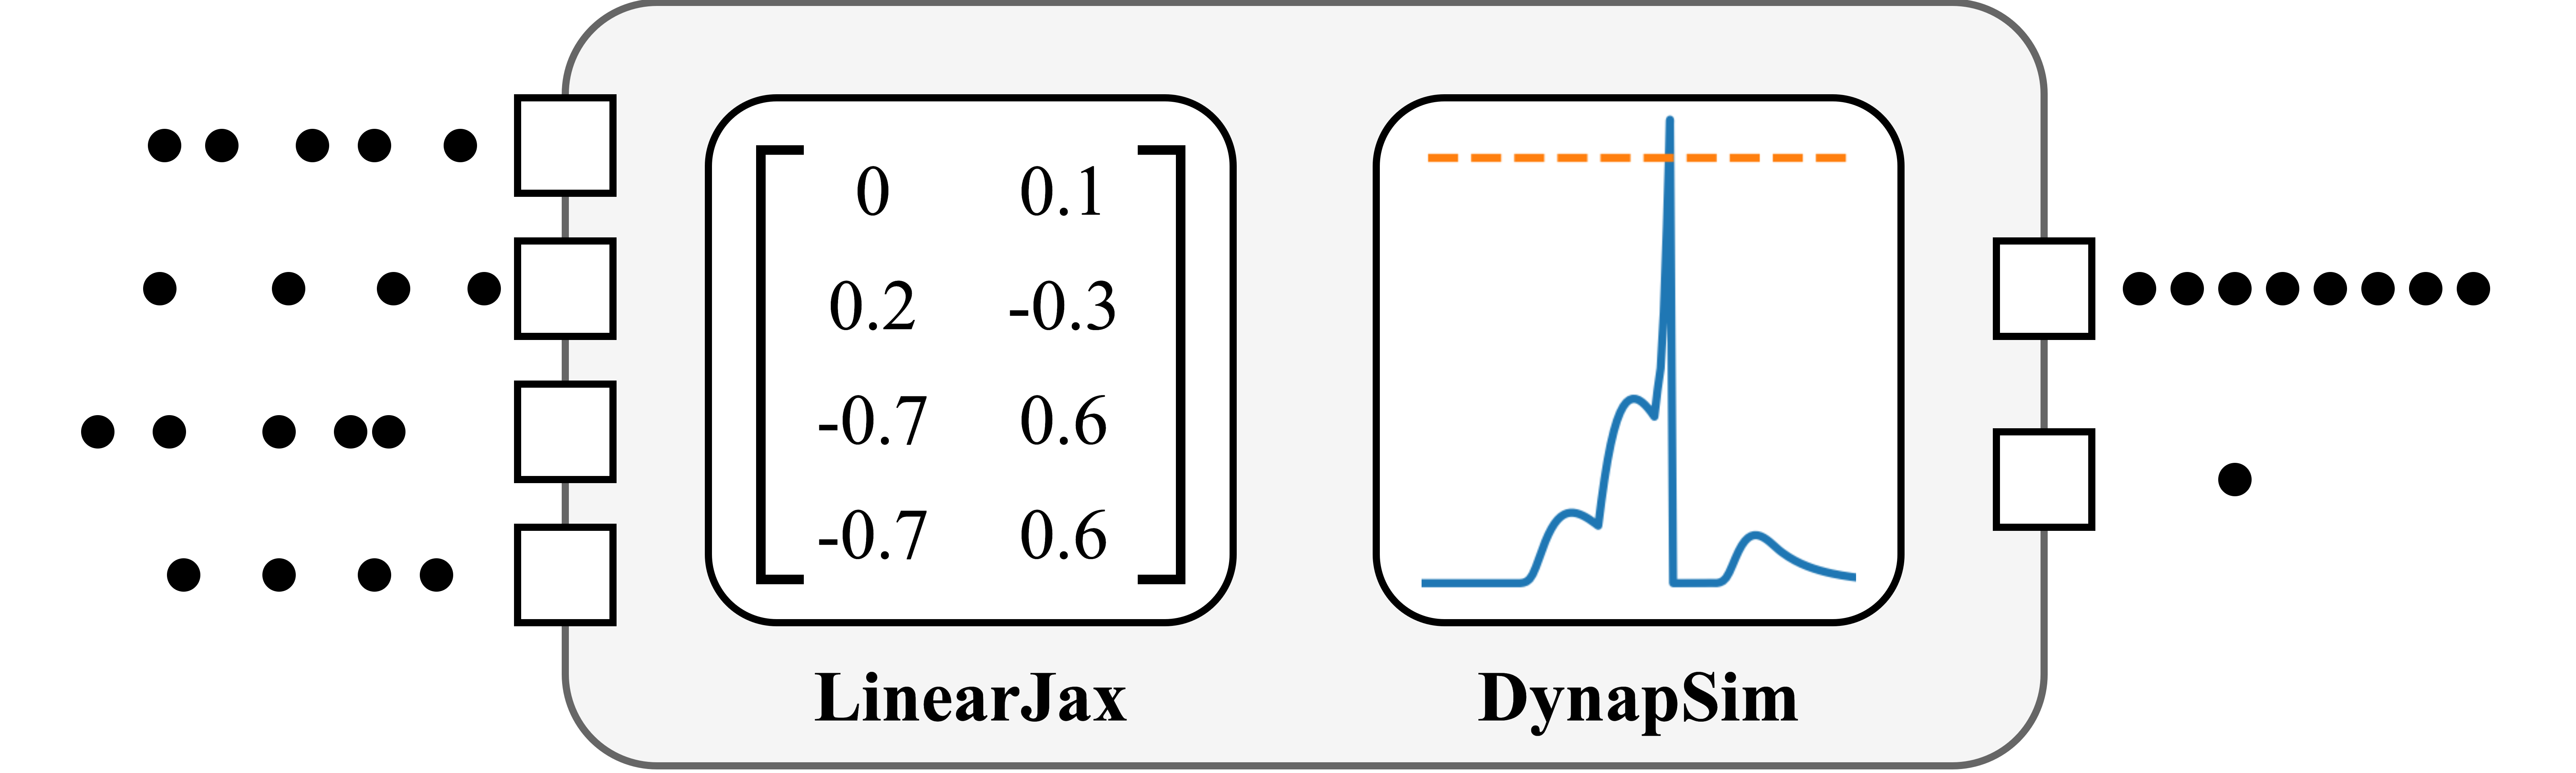

In [1]:
from IPython.display import Image
Image("images/frozen_noise.png", width=960)


This toy task is named as "Frozen Noise Classification".
This experiment aims to train a Dynapsim network to classify two randomly generated frozen noise patterns.
The network includes 2 analog neurons with recurrent connections and 60 external input connections.
The target behavior is when the network receive the first frozen noise, the first neuron will fire at a significantly higher rate.
Accordingly, receiving the second frozen noise, the second neuron should fire at a significantly higher rate.


## Imports

In [2]:
# Utils
import numpy as np
from tqdm import tqdm

# Rockpool Imports
from rockpool.timeseries import TSEvent
from rockpool.nn.modules.jax import LinearJax
from rockpool.nn.combinators import Sequential

## Jax Imports
import jax
from jax import random as rand
from jax import numpy as jnp
from jax.example_libraries.optimizers import adam
from rockpool.training import jax_loss as jl


from rockpool.devices.dynapse import DynapSim, dynamic_mismatch_prototype
from rockpool.transform.mismatch import mismatch_generator

from utils import FrozenNoiseDataset, plot_model_response, plot_model_response_histogram

# - Plotting and config
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [9.6, 3.6]
plt.rcParams["figure.dpi"] = 1200
plt.rcParams["font.size"] = 12


/Users/ugurcancakal/rockpool/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


## Tutorial Utils

In [3]:
%psource FrozenNoiseDataset

class FrozenNoiseDataset:
    """
    FrozenNoise is a synthetic dataset implementation for testing DynapSE-2 simulation pipeline.
    It generates possion spike train rasters

    :param n_samples: number of samples included in the dataset
    :type n_samples: int
    :param n_channels: number of spiking channels (input neurons), defaults to 60
    :type n_channels: int, optional
    :param duration: the duration of each synthetic recording, defaults to 500e-3
    :type duration: float, optional
    :param dt: The discrete time resolution of the recording, defaults to 1e-3, defaults to 1e-3
    :type dt: float, optional
    :param rate: mean firing rate in Hz (applies to all channels), defaults to 50
    :type rate: float, optional
    :param seed: random number generator seed, defaults to 2022
    :type seed: Optional[float], optional
    """

    def __init__(
        self,
        n_samples: int,
        n_channels: int = 60,
        duration: float = 500e-3,
        dt: float = 1e

In [4]:
%psource plot_model_response

def plot_model_response(
    model: JaxModule,
    dataset: FrozenNoiseDataset,
    dt: float,
    slice: Optional[List[int]] = None,
) -> None:
    """
    plot_model_response is a utility function which simulates the given model with the samples of the dataset choosen.

    :param model: the jax model to be simulated
    :type model: JaxModule
    :param dataset: a frozen noise dataset instance
    :type dataset: FrozenNoiseDataset
    :param dt: the simulation time step
    :type dt: float
    :param slice: the indices of the dataset chosen, defaults to None
    :type slice: Optional[List[int]], optional
    """

    if slice is None:
        slice = range(len(dataset))

    for i in slice:
        plt.figure()
        # Get sample
        sample, _ = dataset[i]

        # Run simulation
        model.reset_state()
        out, _, _ = model(sample)
        frr_flat = np.sum(out, axis=1).flatten()
        frr = max(frr_flat) / min(frr_flat)
        # Plot the spiking output
        T

## Step 1 : Synthetic Dataset Generation

The frozen noise patterns have a mean frequency of 50 Hz in 500 ms duration.
Each sample has 60 channels, meaning each can be regarded as a composition of 60 discrete poisson time series.
The discrete time-step length is 1 ms.
The `train_data` samples will be used to train the network.

The `test_data` samples will be used to provide a negative test.
Test dataset includes the same mean frequency, the same duration samples. 
The trained network does expose a clear decision for them, because the network is not trained for this.

In [5]:
train_data = FrozenNoiseDataset(2)
test_data = FrozenNoiseDataset(100, seed=2023)

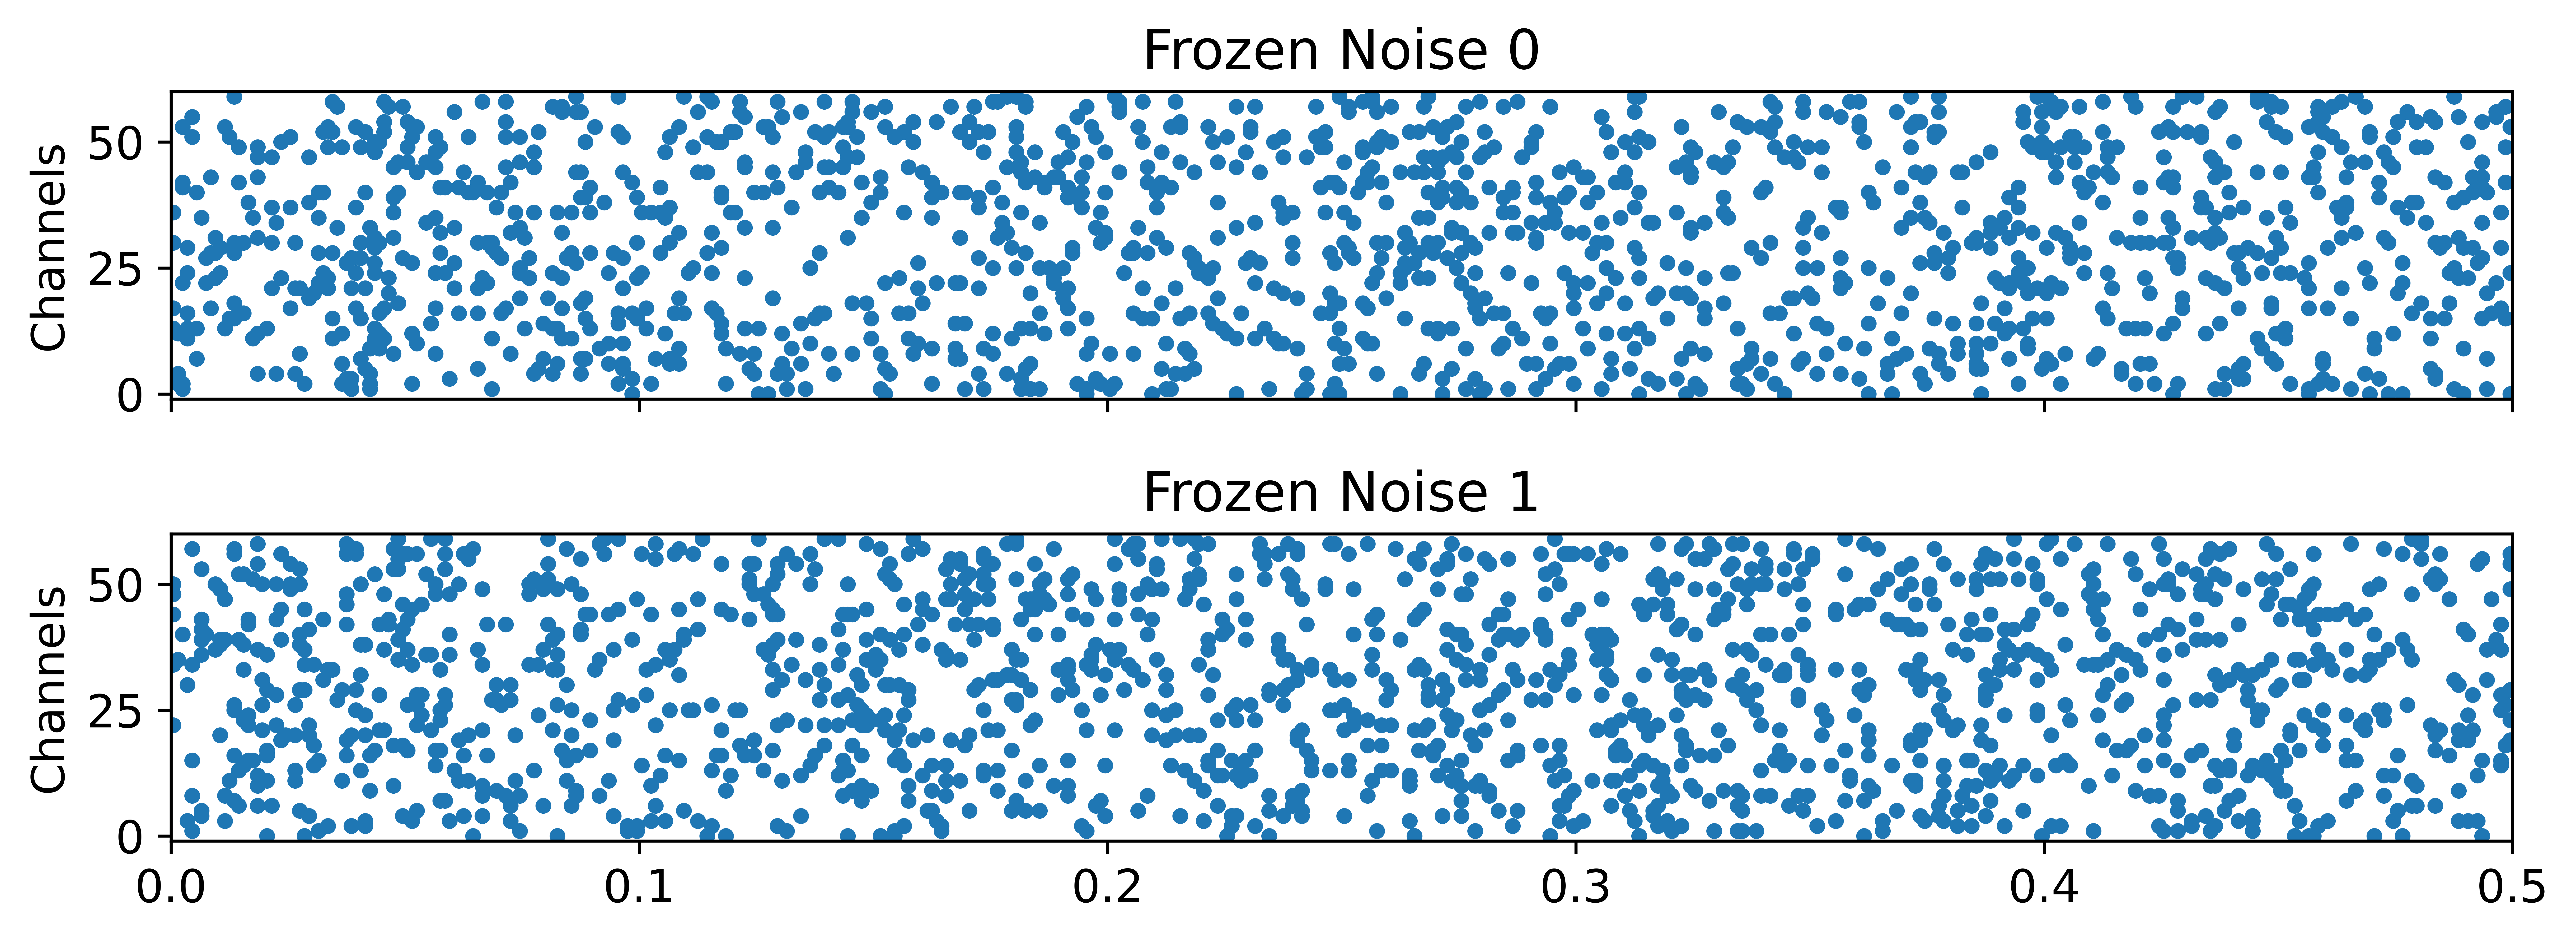

In [6]:
train_data.plot_samples()

## Step 2 : Build a network in Rockpool

Similar to quick start tutorial, we will build the network by defining the input and output dimensions.
Different from the quick start, we will use the mismatch simulation. 

Being a mixed signal chip, Dynap-SE2 suffers from the analog device mismatch issue that all those analog processors face, too. 

Check references:

* Büchel, J., Zendrikov, D., Solinas, S. et al. Supervised training of spiking neural networks for robust deployment on mixed-signal neuromorphic processors. Sci Rep 11, 23376 (2021).

* Zendrikov, D., Solinas, S., & Indiveri, G. (2022). Brain-inspired methods for achieving robust computation in heterogeneous mixed-signal neuromorphic processing systems. bioRxiv.

Device mismatch simulation deviates the parameters with a gaussian distribution, pinning the initial values as the mean values.
In this way, the simulator can expose the reality better.

In [7]:
Nin = train_data.n_in
Nrec = train_data.n_out
dt = 1e-3

In [8]:
net = Sequential(
    LinearJax(shape=(Nin, Nrec), has_bias=False),
    DynapSim((Nrec, Nrec), has_rec=True, percent_mismatch=0.05, dt=dt),
)
net

JaxSequential  with shape (60, 2) {
    LinearJax '0_LinearJax' with shape (60, 2)
    DynapSim '1_DynapSim' with shape (2, 2)
}

### Step 2.1 : The initial Results of Frozen Noise 0

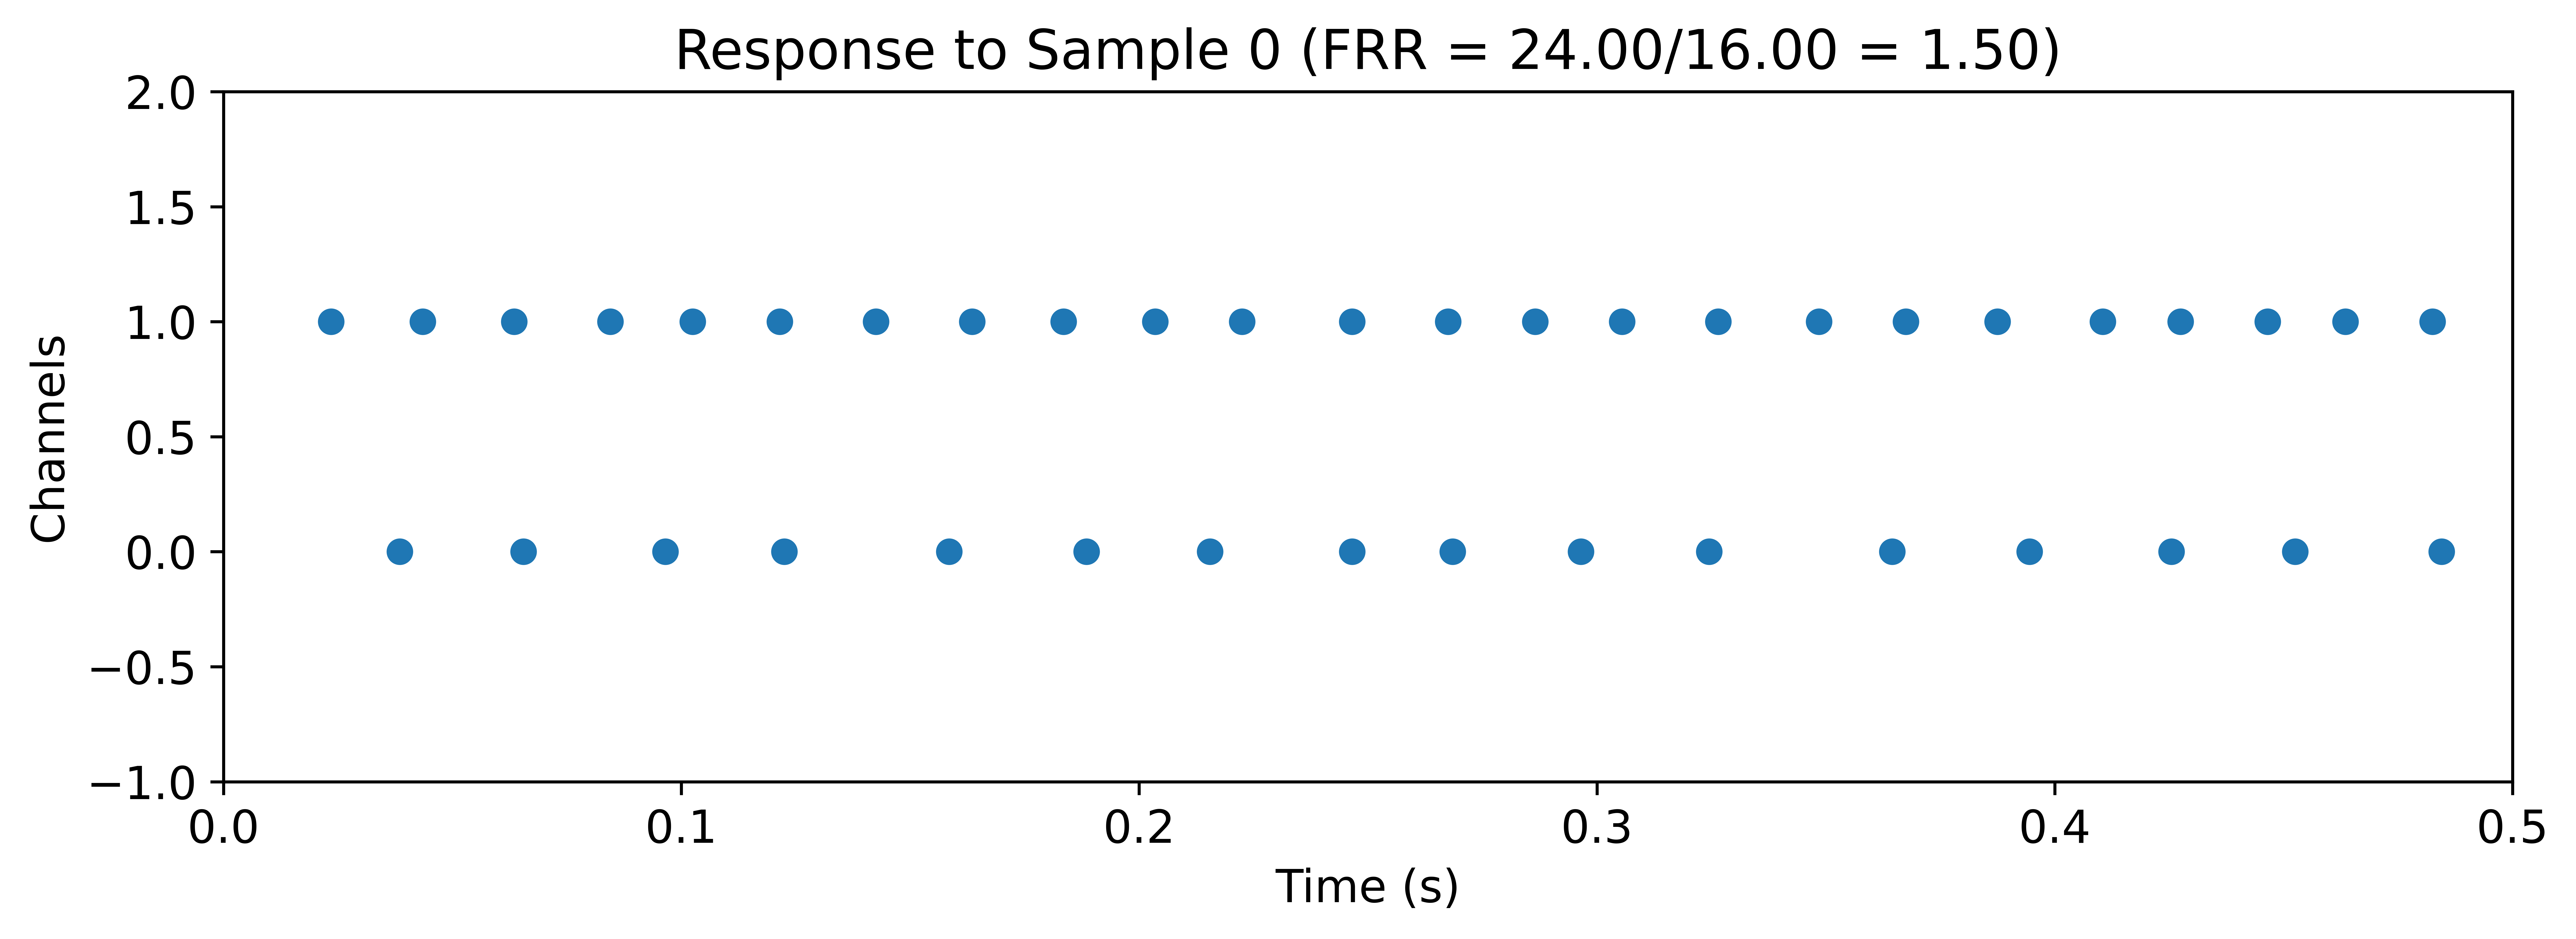

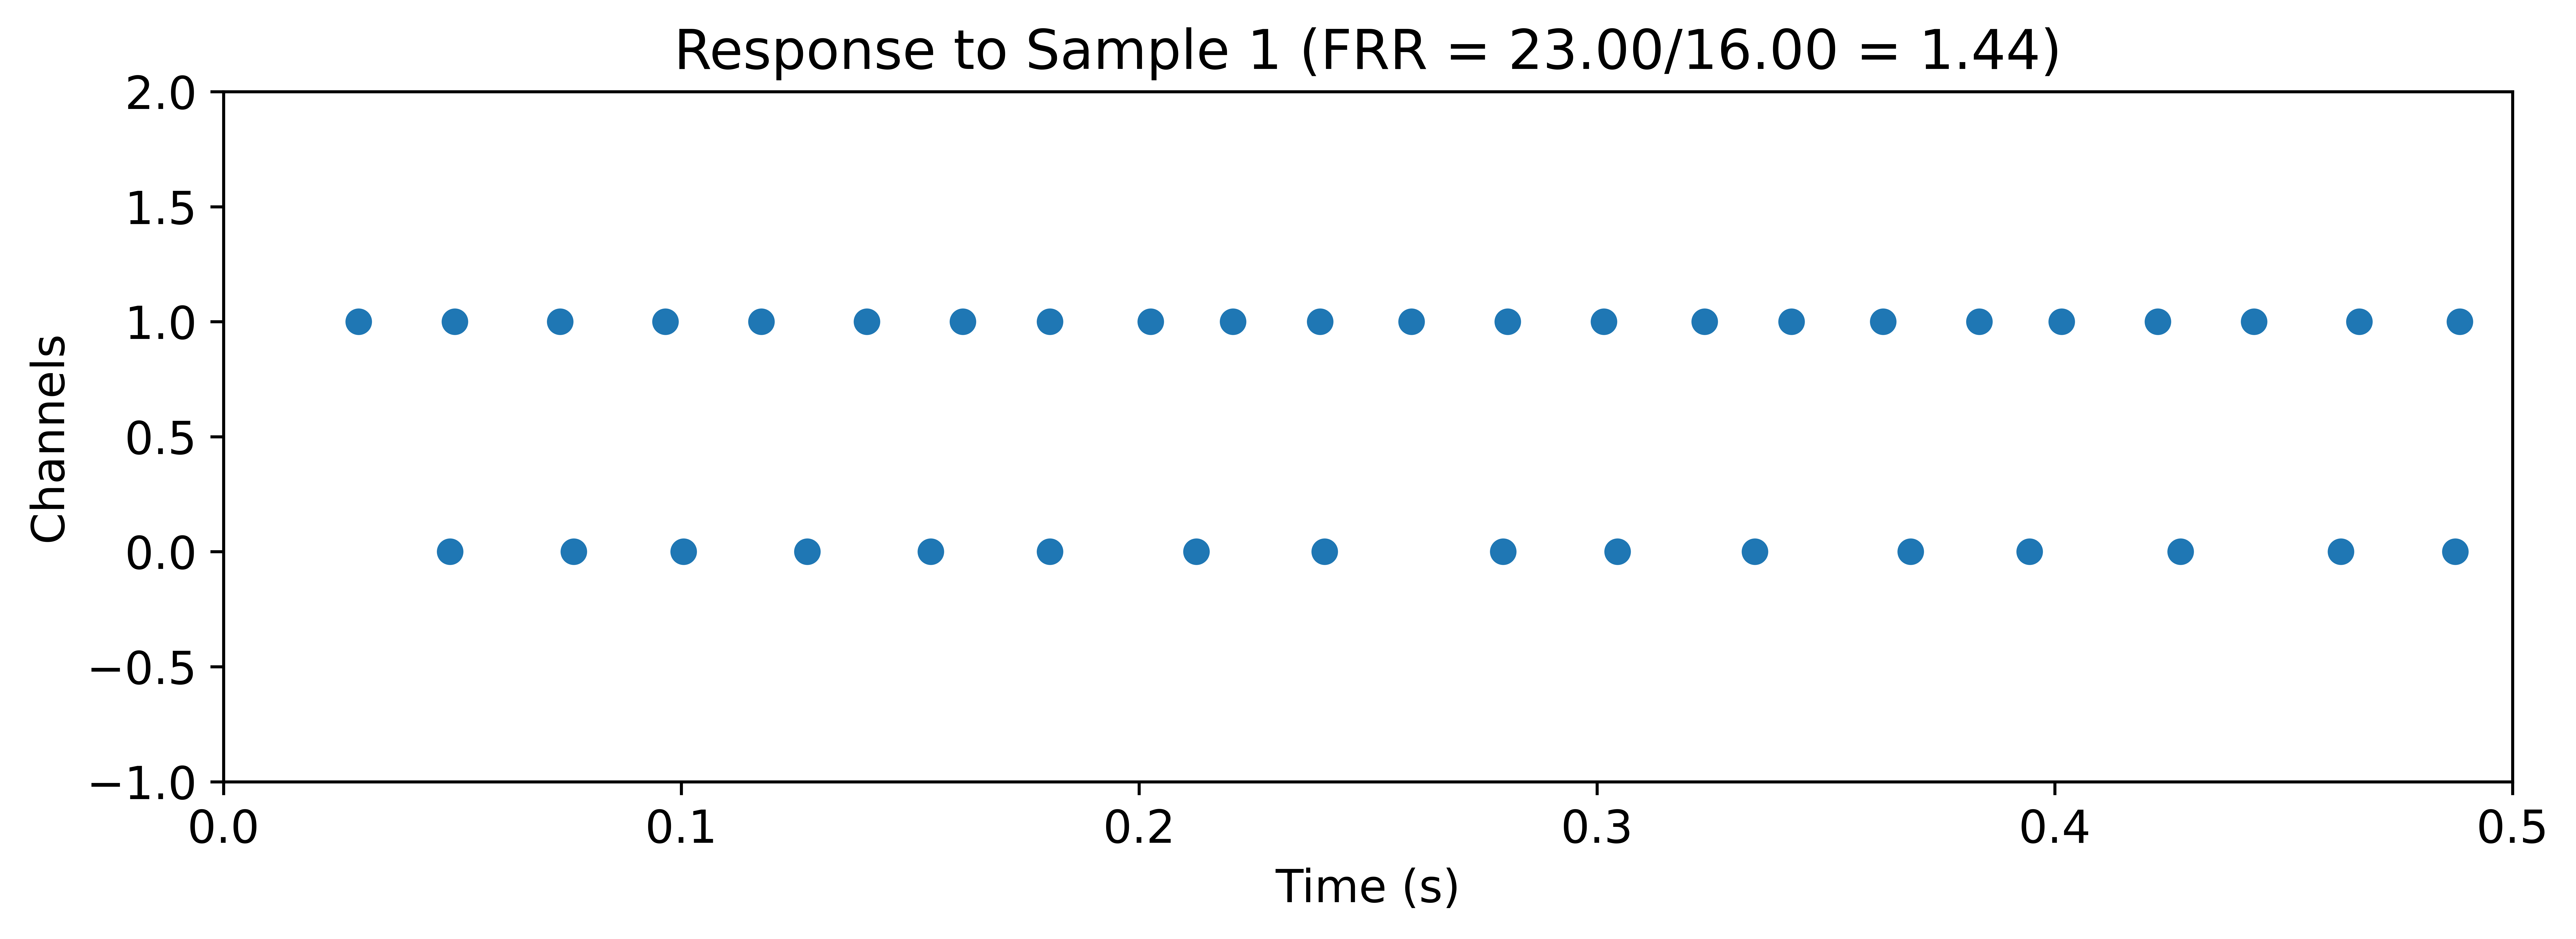

In [9]:
plot_model_response(net, train_data, dt)

## Step 3 : Response Analysis

The figures above shows that the network reacts similarly to given different noise patterns.
In order to put a figure on the network's response, neurons mean firing rates in the given duration are computed by summing up all the spikes generated and dividing by the number of timesteps.

$$
    r = \dfrac{1}{dt \cdot N} \cdot \sum_{i=0}^{N} S[i]
$$

On top of that, to compare the neurons' capability to distinguish the frozen noise patterns, the ratio between neurons' mean firing rate is used.
The firing rate ratio (**FRR**) is the ratio between the superior and inferior mean firing rates read from the decision neurons.
FRR is calculated as follows:

$$
    FRR = \dfrac{r_{\text{superior}}}{r_{\text{inferior}}}
$$

It's seen that the outputs of the neurons are almost identical receiving the frozen noise patterns of similar discrete time series of events.
The number is pretty close to each others and to 1.
This shows that the randomly initialized DynapSim network is insensitive to the noise patterns.
Below, a collection of firing rate responses of the initial network to the test data is given.

Histogram: 100 iteration [00:17,  5.73 iteration/s]               
WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6611: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
 [py.warnings]
  xmin = min(xmin, np.nanmin(xi))

WARNING    /Users/ugurcancakal/rockpool/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6612: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
 [py.warnings]
  xmax = max(xmax, np.nanmax(xi))



ValueError: autodetected range of [nan, nan] is not finite

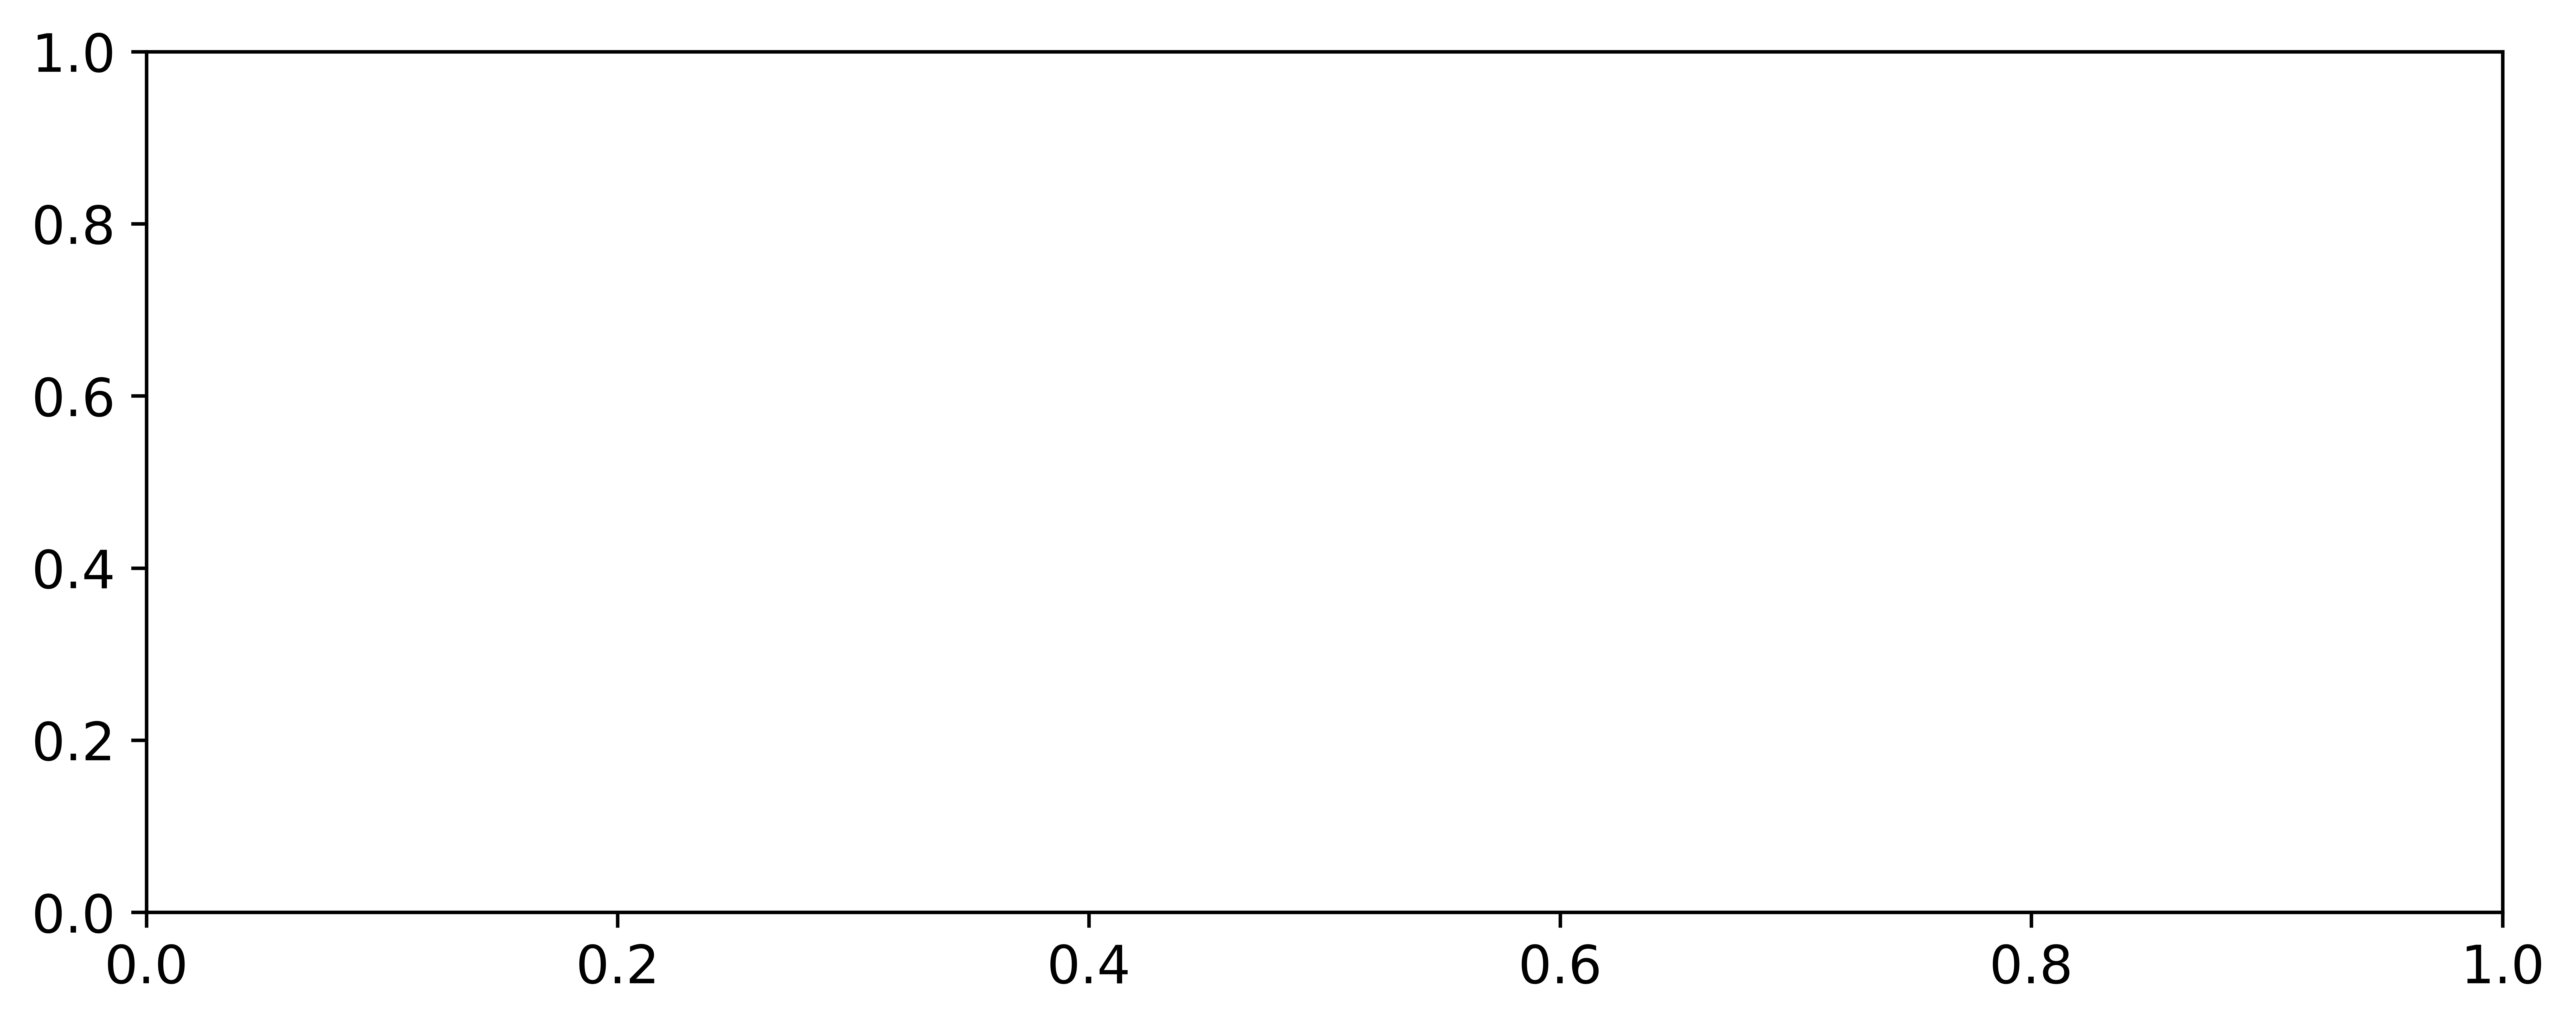

In [21]:
plot_model_response_histogram(net, test_data)

In order to teach the network to sense the temporal nuances hidden in these time series, a gradient-based optimization procedure will be executed next.
The following sections present this procedure, starting from introducing the objective function.

## Step 4 : Optimization

The objective of the optimization is to make one of the neurons fire at a noticeably higher rate upon receiving a specific frozen noise.
For example, if frozen noise 1 is dispatched to the device then neuron 1 should fire dominantly, and if frozen noise 2 is dispatched, neuron 2 firing should dominate the output reading.
In order to achieve this behavior, mean square error (MSE) loss is exploited.

### Step 4.1 Loss Function
$$
    f_{\text{MSE}}(y_{\text{out}}, y_{\text{target}}) = \dfrac{1}{N} \sum_{i=0}^N \left( y_{\text{out}}[i] - y_{\text{target}}[i]\right)^{2}
$$

The target train is a uniform spike train that has an event at every time step.

In [11]:
# - Loss function
@jax.jit
@jax.value_and_grad
def loss_vgf(params, net, input, target):
    net = net.set_attributes(params)
    net = net.reset_state()
    output, _, _ = net(input)
    return jl.mse(output, target)

Even though, the training objective is to make the neuron fire constantly, the actual neuron model is not capable of producing exactly the same ideal spike train.
The refractory periods and spike frequency adaptation mechanism prevent the neuron from firing incessantly.
Therefore, it's impossible to get zero error in any case.
The optimizer pushes the neurons to do their best to converge to the ideal spiking regime.
The expected training behavior is that the error will start high and then gradually drop down to a level that is definitely above zero.

### Step 4.2 Optimizer

To update the weight matrices such that the network would achieve the least possible mean square error, a gradient-based optimization procedure is applied.
In this experiment, a popular gradient descent variation, Adaptive Moment Estimation, **Adam**, is used.
This method provides a first-order gradient-based optimization of stochastic objective functions based on adaptive estimates of lower-order moments.


In [12]:
# - Initialise optimiser
init_fun, update_fun, get_params = adam(step_size=1e-3)
opt_state = init_fun(net.parameters())
update_fun = jax.jit(update_fun)

### Step 4.3 Mismatch Generator (Optional)

This step is not necessary to train a `DynapSim` network, but highly suggested. As explained above, the hardware suffers from device mismatch, and we already initiated the model with a frozen mismatch. On top of it, deviating parameter values during training, would give us a better, more robust parameter space.


In [13]:
# Obtain the prototoype and the random number generator keys
rng_key = jnp.array([2021, 2022], dtype=jnp.uint32)
mismatch_prototype = dynamic_mismatch_prototype(net)

# Get the mismatch generator function
regenerate_mismatch = mismatch_generator(mismatch_prototype, percent_deviation=0.30, sigma_rule=3.0)
regenerate_mismatch = jax.jit(regenerate_mismatch)

### Step 4.5 Run the trainin loop

Each training step, or epoch, includes a forward and a backward pass.
The forward pass simulates the neural dynamics in time and produces the spike trains.
The backward pass backpropagates the error in time, assigning the credits to weight values.
Since the forward computation introduces indifferentiable functions, a surrogate function approximation is used in the backward pass.
(see neuron model tutorial for more)
As a result, the weight values get small updates in each time step fixing the behavior slightly in the approximate continuous space.

So,

this will take time..

You can wait or you can use the pre-trained weights for later stages.

In [14]:
# - Configure learning
num_epochs = int(1e6)
apply_mismatch = 100
loss_t = []

# - Get input and target batches
batch_input, batch_target = train_data.full_batch

# - Training loop
t = tqdm(range(num_epochs), desc='Training', unit='Epoch', total=num_epochs)

for epoch in t:
    
    # - Get parameters
    opt_parameters = get_params(opt_state)

    # - Regenerate mismatch once in a while
    if epoch%apply_mismatch == 0:
        rng_key, _ = rand.split(rng_key)
        new_params = regenerate_mismatch(net, rng_key=rng_key)
        net = net.set_attributes(new_params)

    # - Compute loss and gradient
    l, g = loss_vgf(opt_parameters, net, batch_input, batch_target)
    loss_t.append(l.item())
    t.set_postfix({'loss': l.item()}, refresh = False)

    # - Update optimiser
    opt_state = update_fun(epoch, g, opt_state)

Training: 100%|██████████| 1000000/1000000 [06:40<00:00, 2494.60Epoch/s, loss=0.453]


## Step 5 : Results

We have trained our network to recognize some given frozen noise patterns. Now it's time to check it's performance

### Step 5.1. Loss Plot

It's seen in the figure that the loss decreased from 0.5 to a non-zero value over many epochs (as expected).
However, even this much drop creates a huge difference in behavior, and the network obtains the ability to classify two similar frozen noise samples.

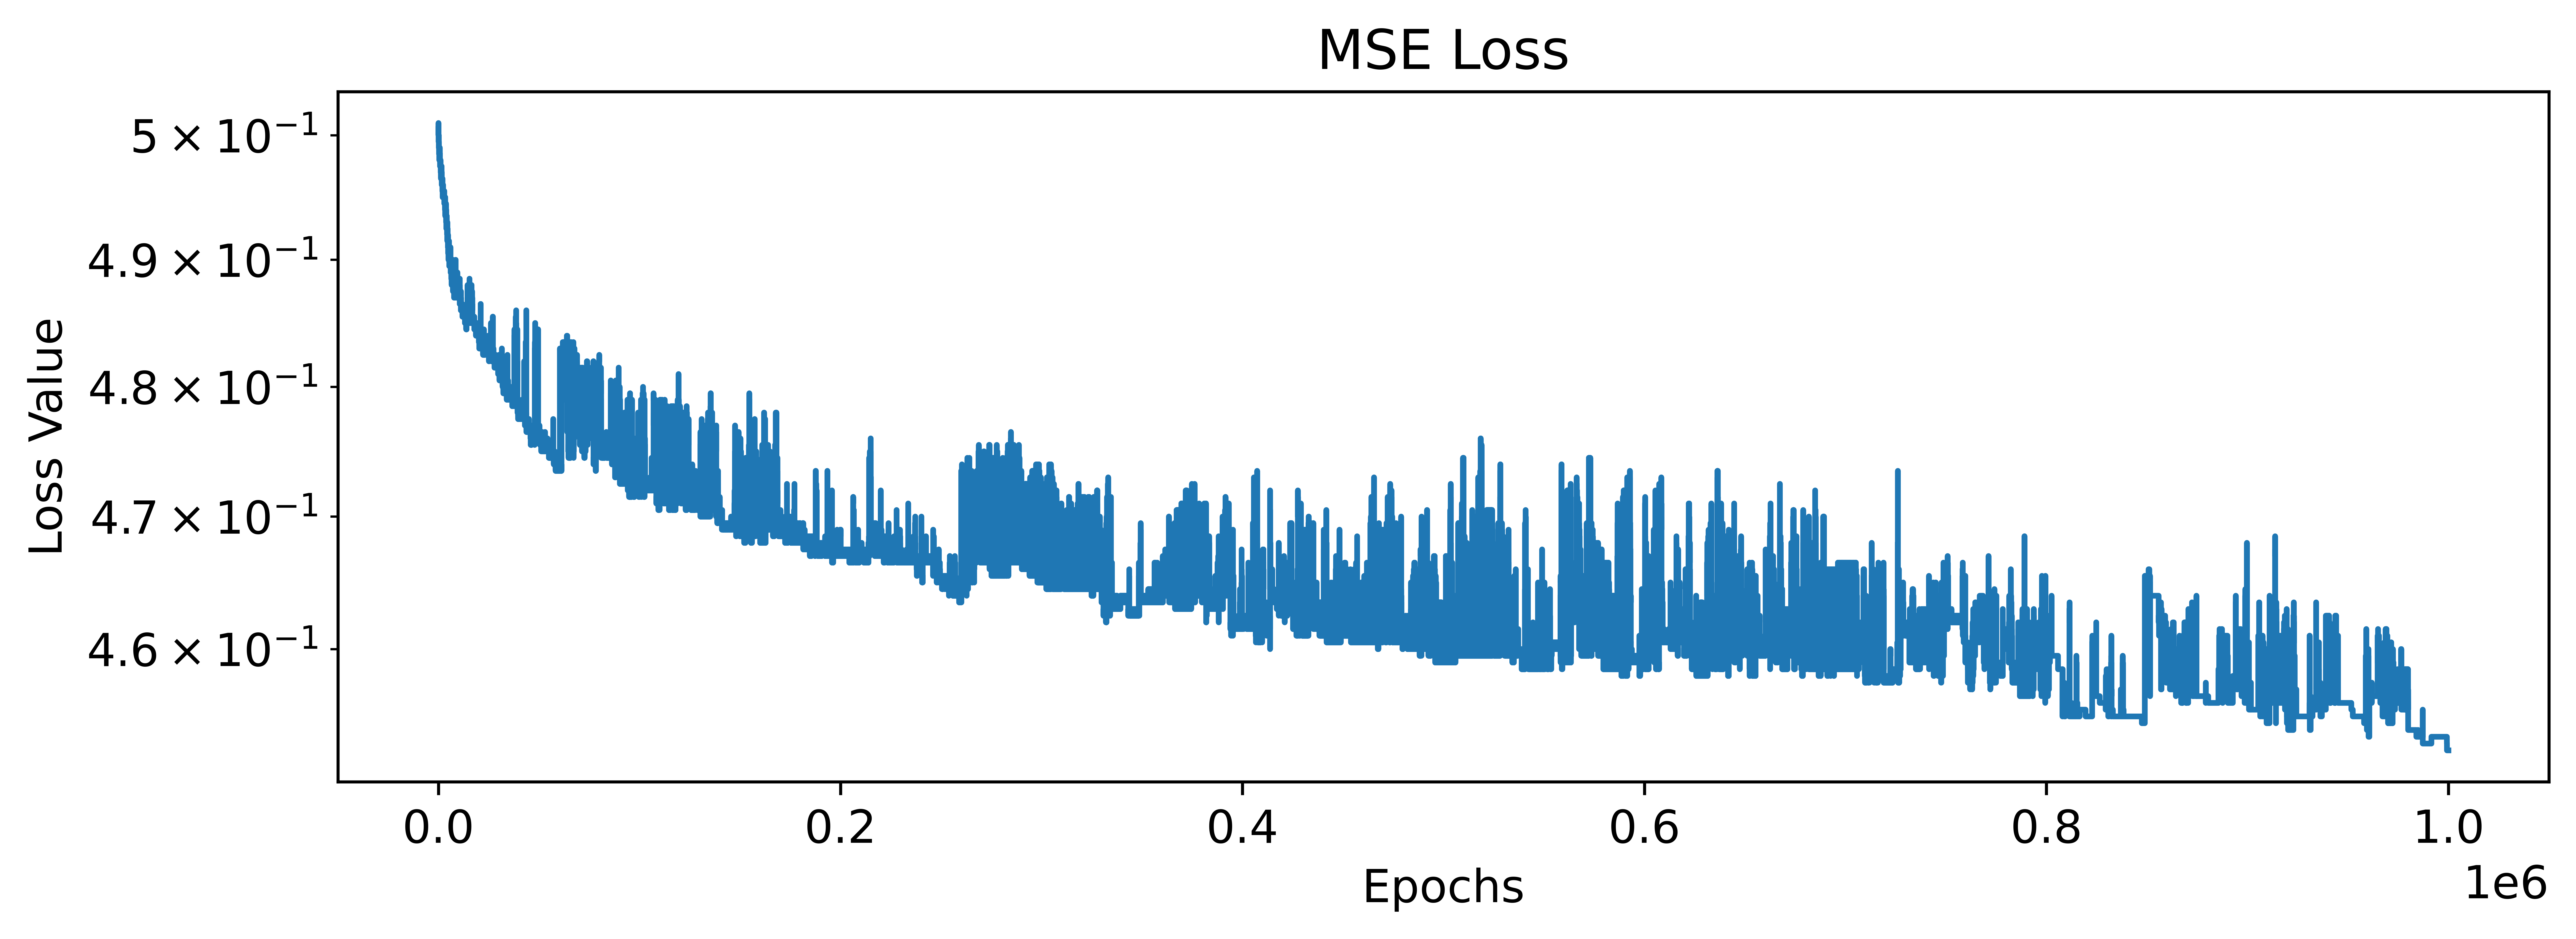

In [15]:
plt.semilogy(loss_t)
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title("MSE Loss")
plt.tight_layout()

### Section 5.2 Get the Optimized Network

As a result of training, the network must have learned to sense the difference between frozen noise patterns.
In order to observe the behavior of the network and compare with the initial version, the optimized network is simulated.

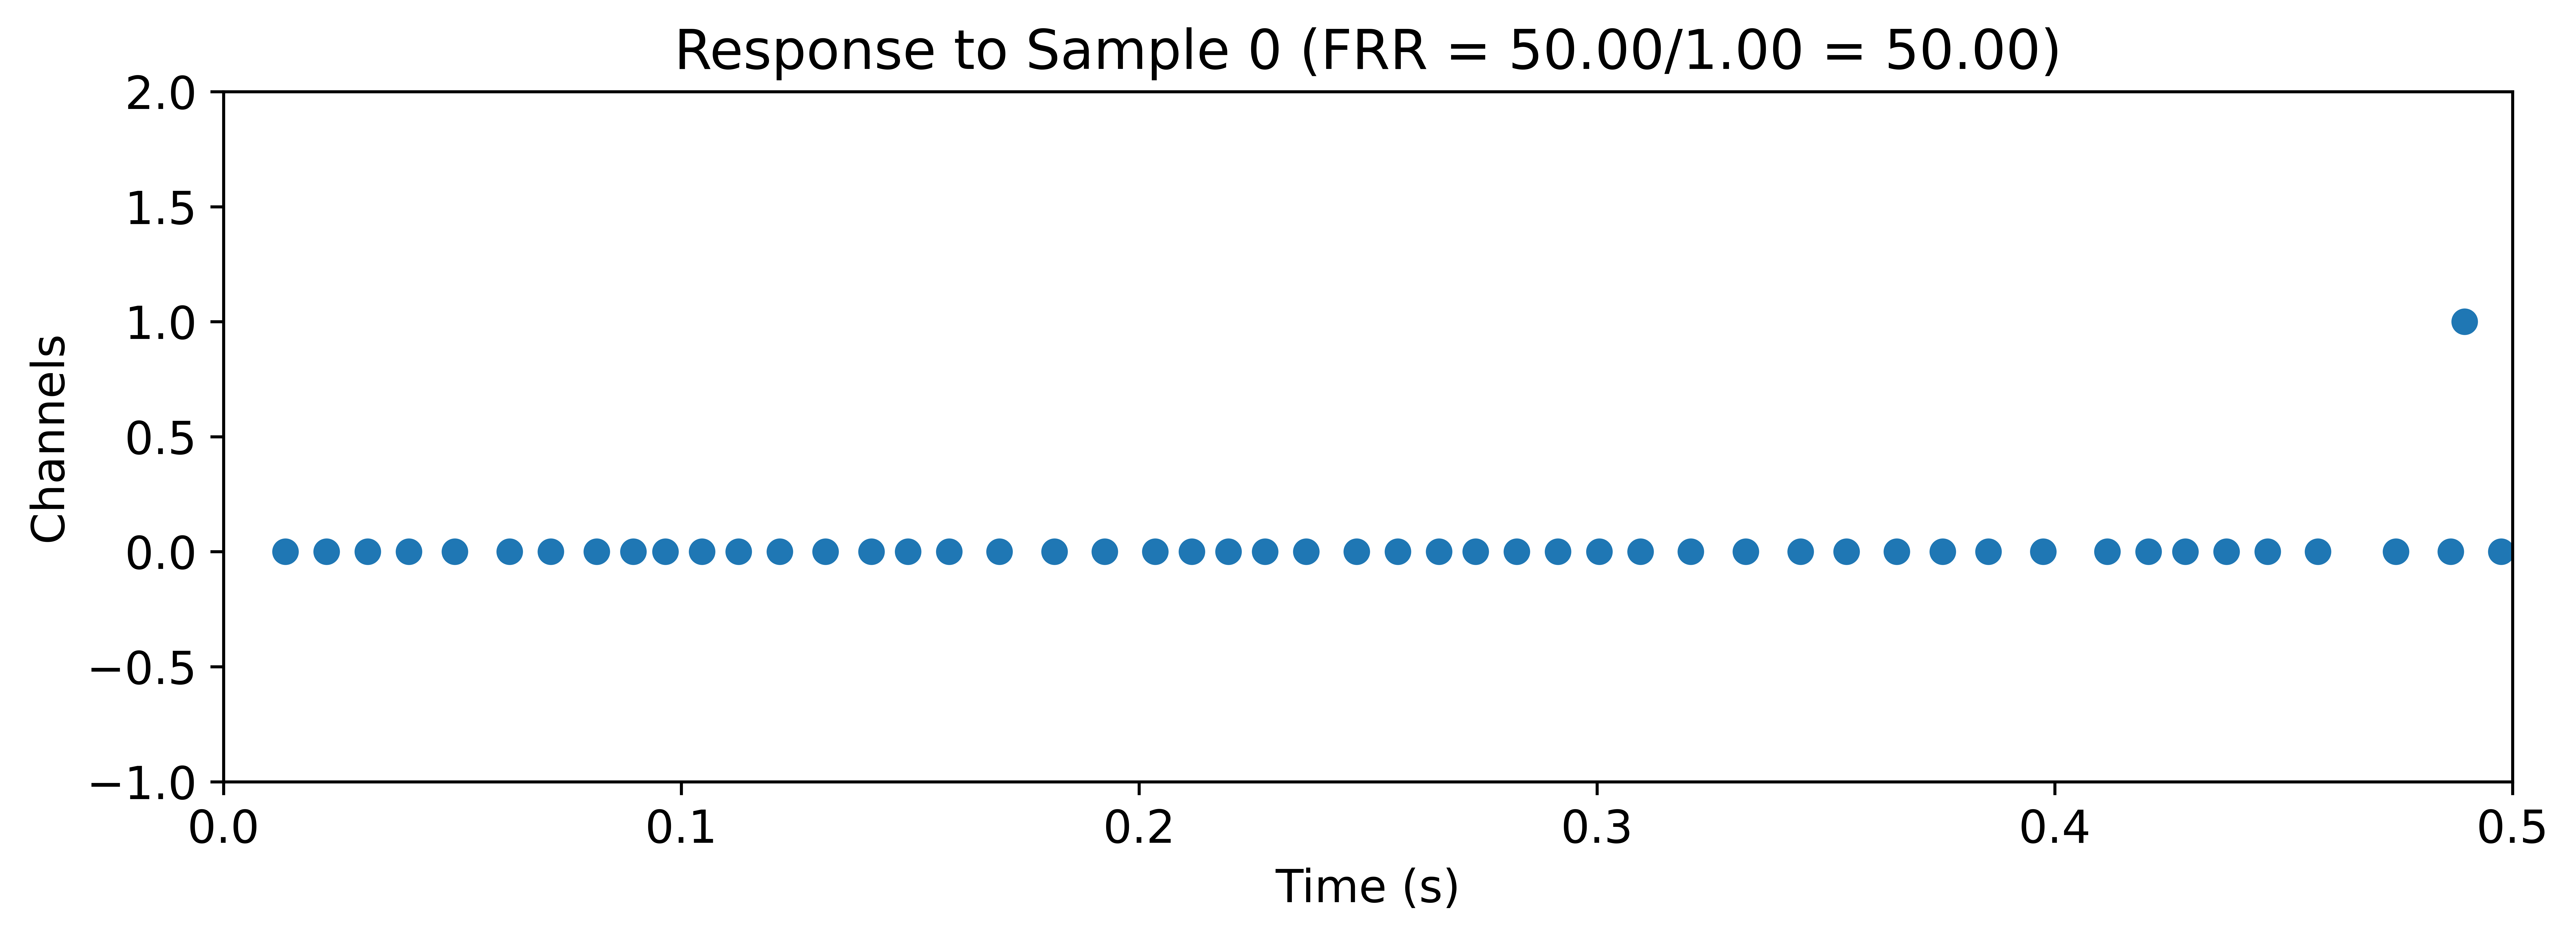

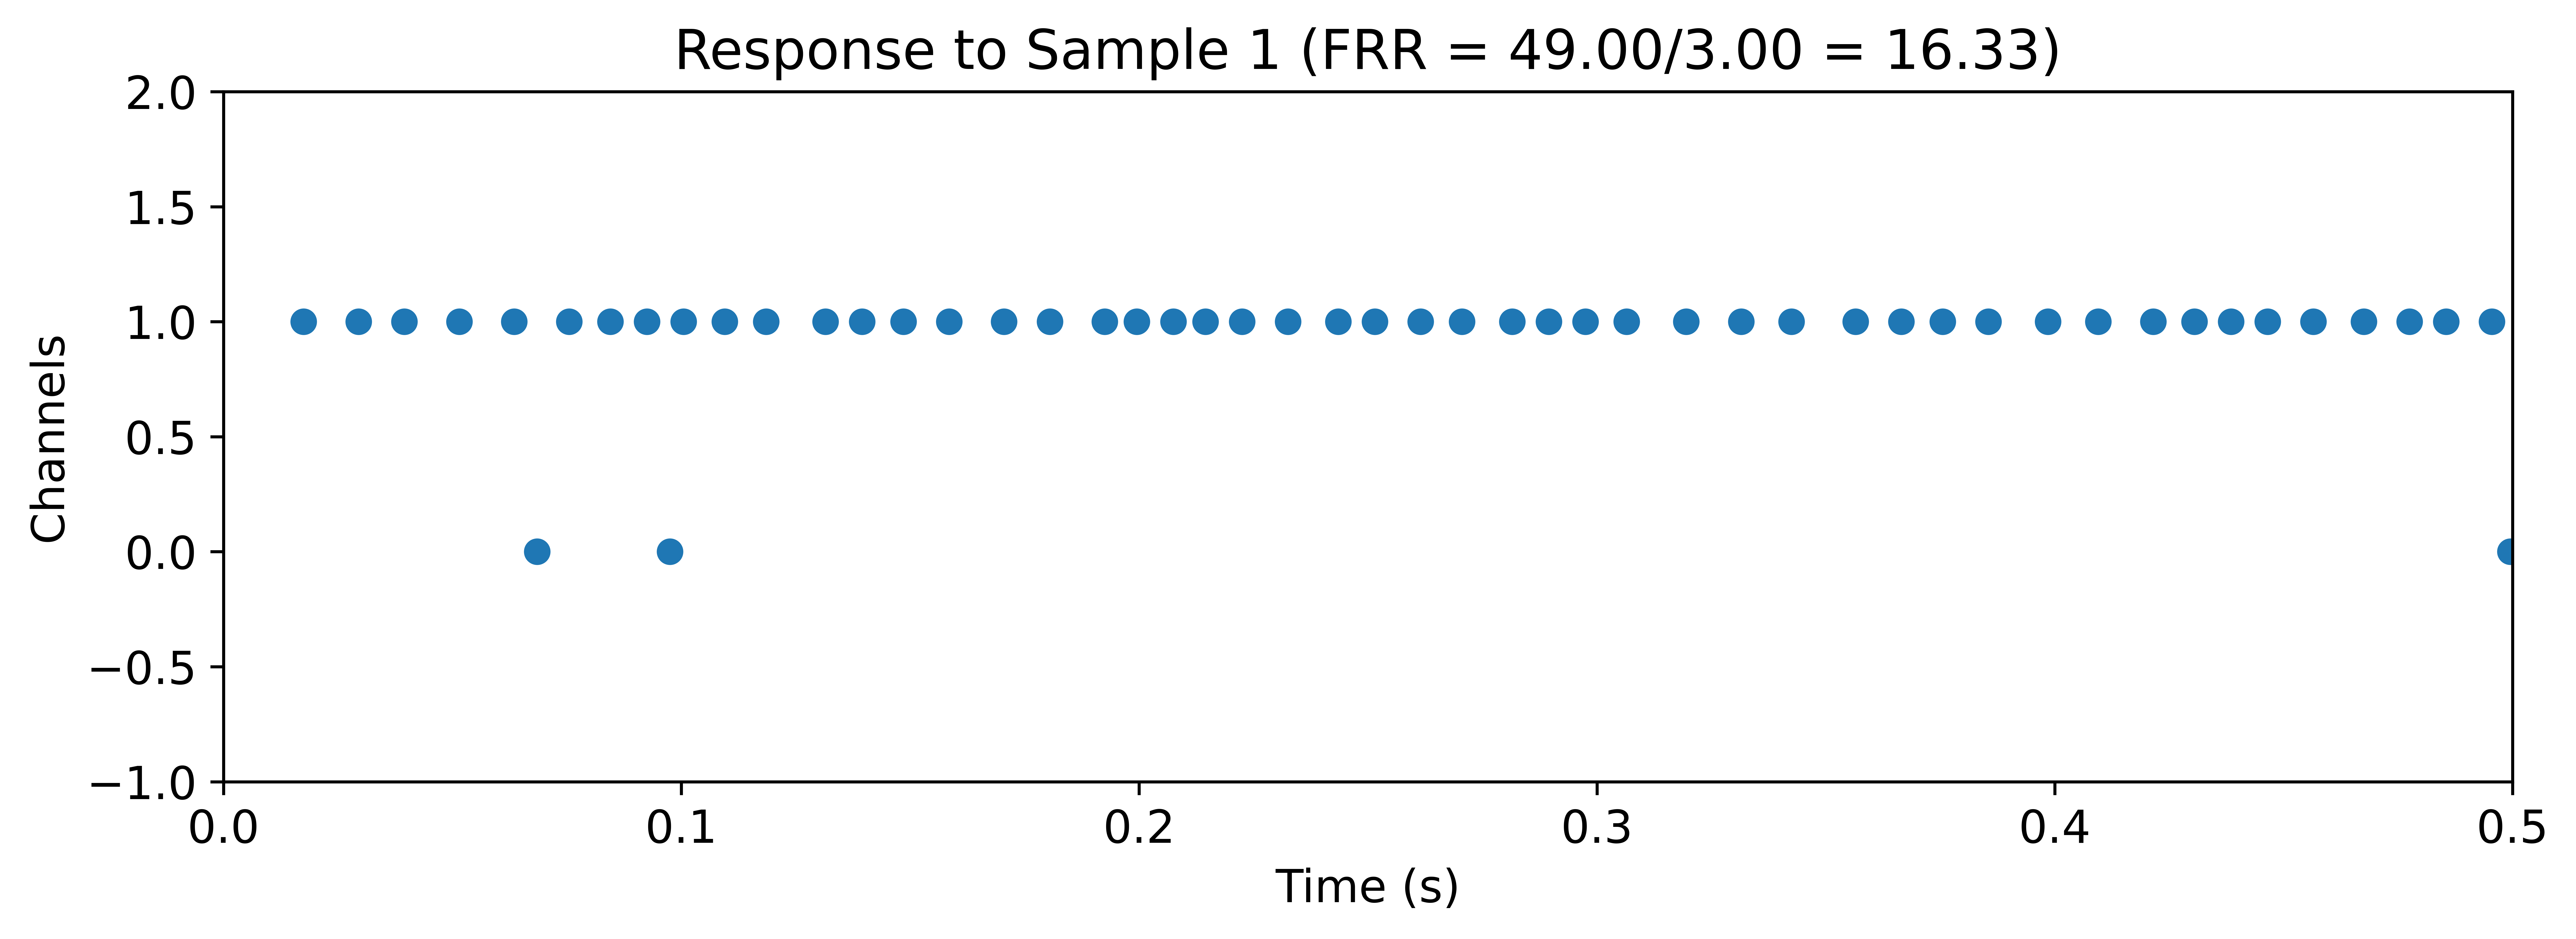

In [16]:
net_optimized = net.set_attributes(get_params(opt_state))
plot_model_response(net_optimized, train_data, dt)

### Section 5.3 : Negative Test


Optimization results show that this tiny recurrent spiking neural network of two `DynapSim` neurons can distinguish one frozen noise from another.
If the optimization requirements were satisfied, then the network should respond clearly to recognized noises and react randomly to anything else.
In other words, decision neurons should fire together or stay silent upon receiving a non-recognized signal.
If one of them fires and the other one stays silent, then it shows that the network can be deceived and the decisions are not reliable.

Now, we will use the test set data to show that our network recognize only the the training samples.
In order to test this, 1000 frozen noise patterns with the same mean frequency and length are generated using the same process used in training data generation.
To prove the rate ratio is dramatically changed only for recognized signals, the FRRs between decision neurons are recorded.

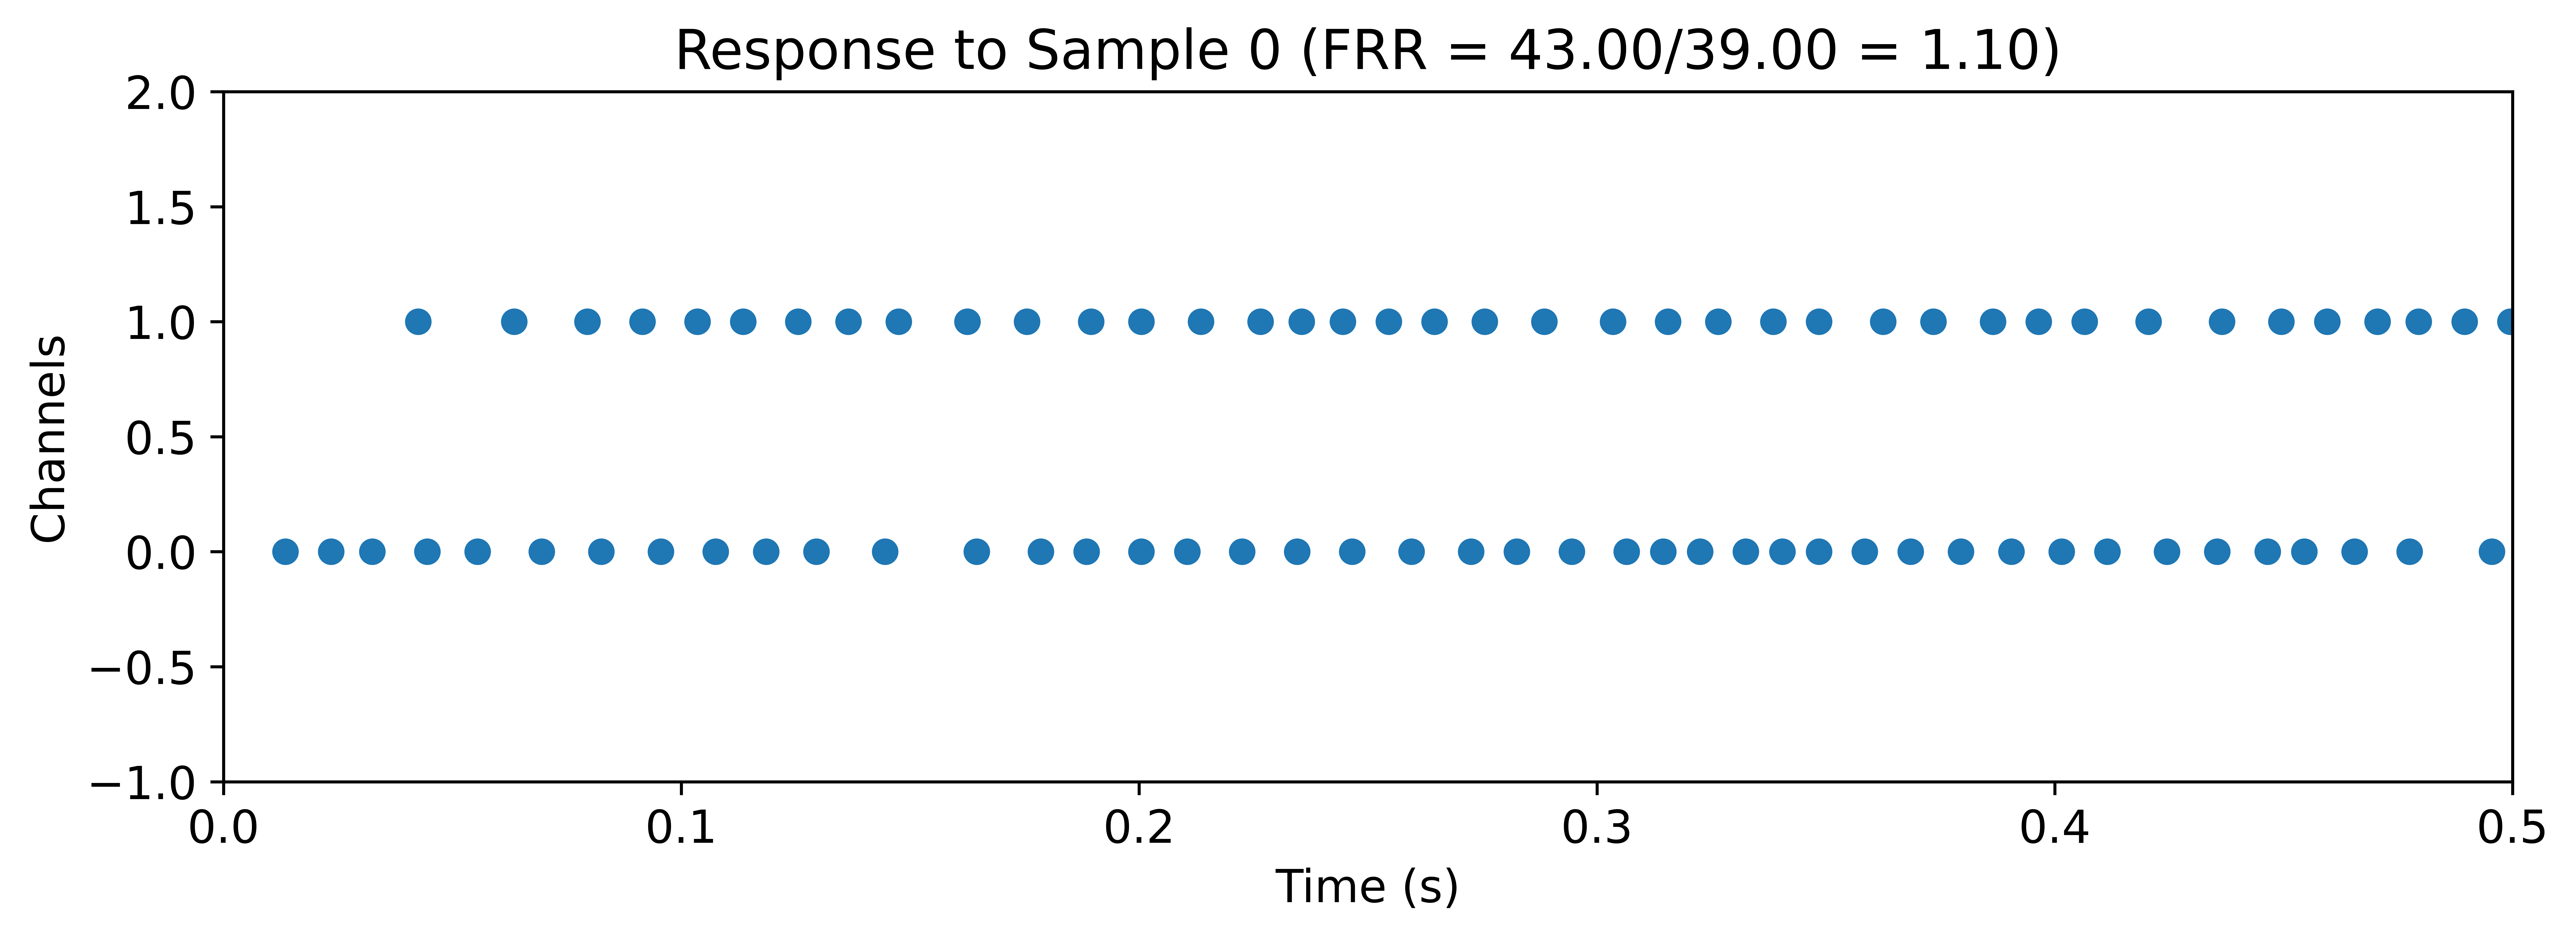

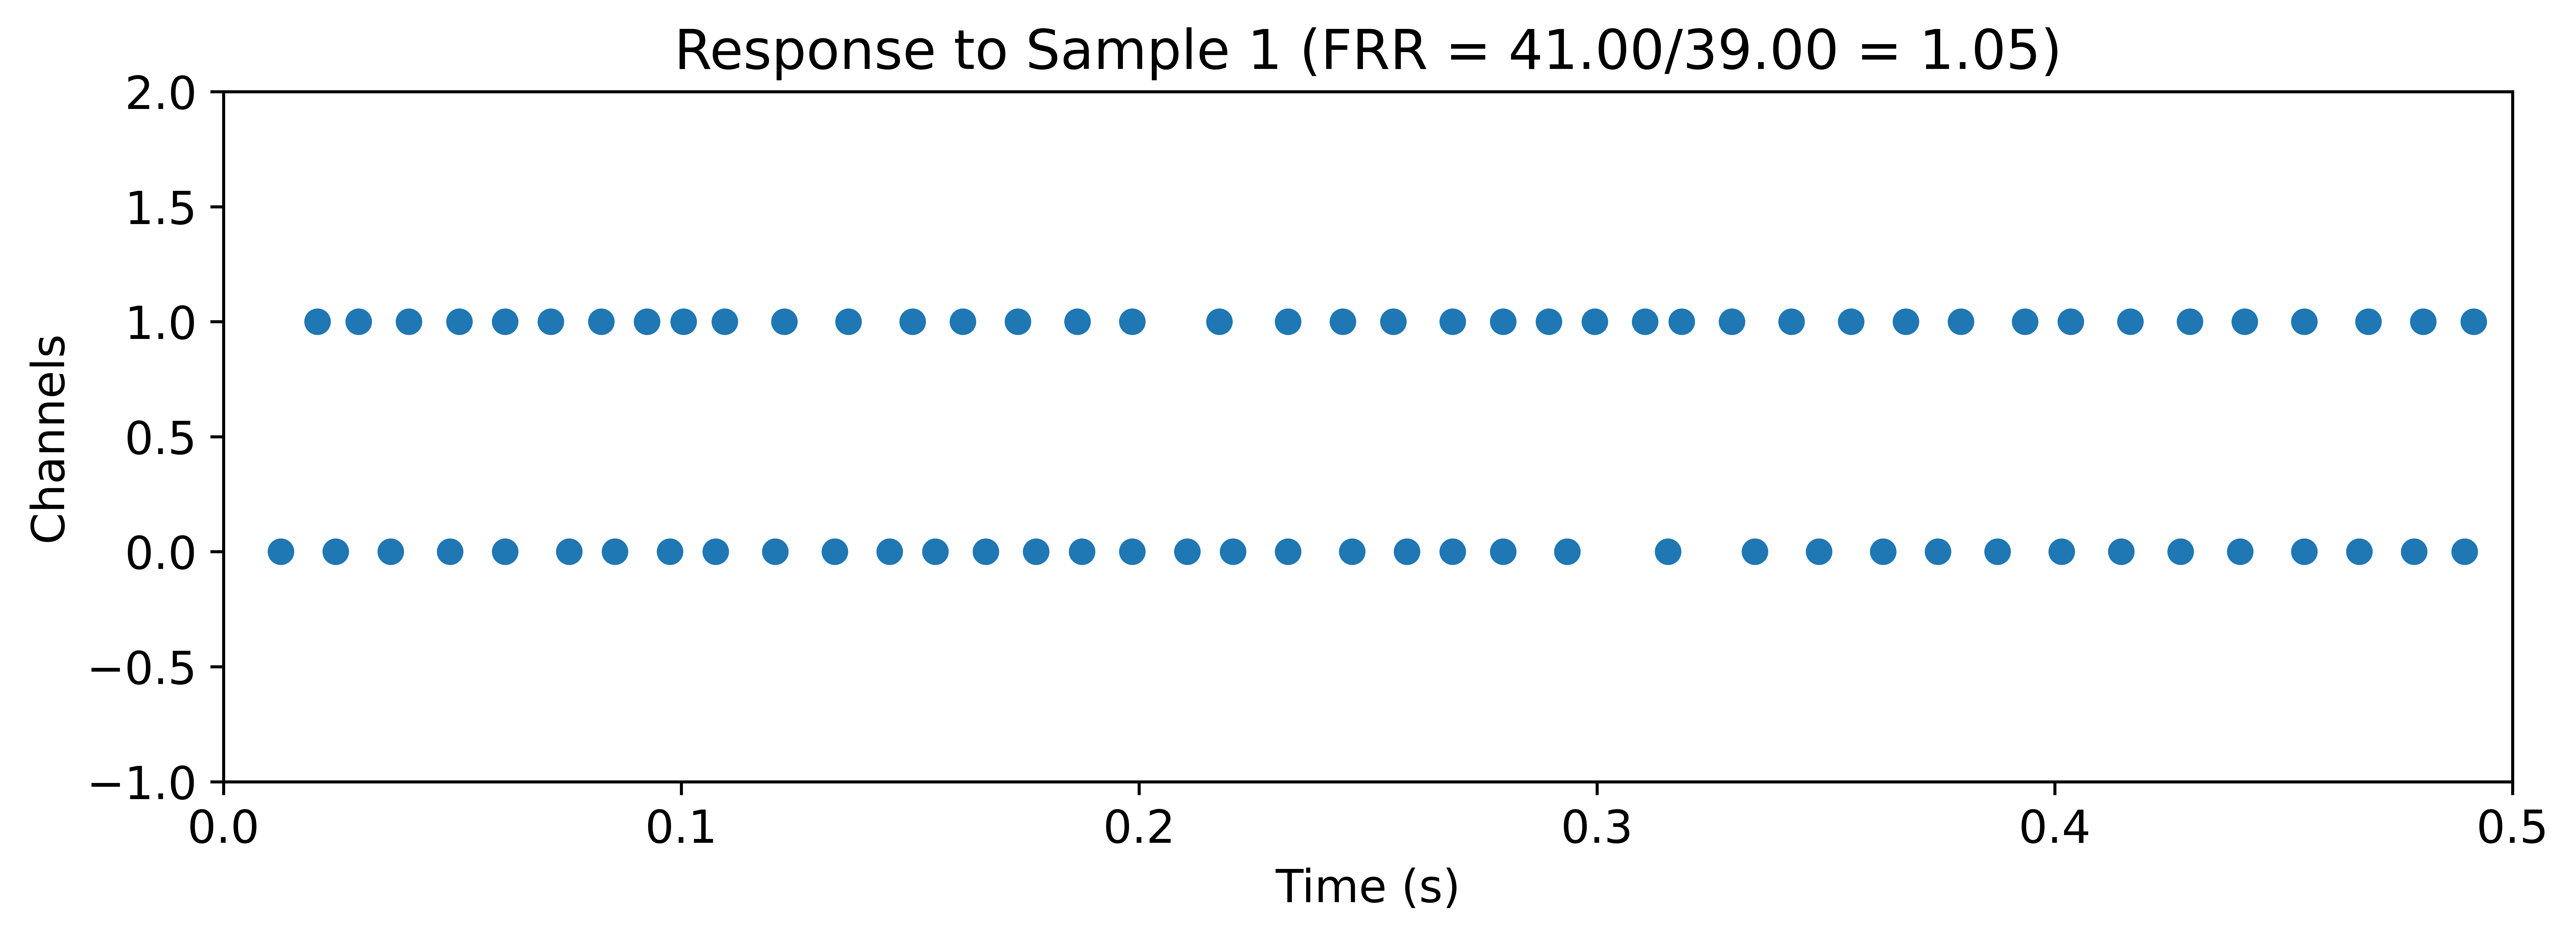

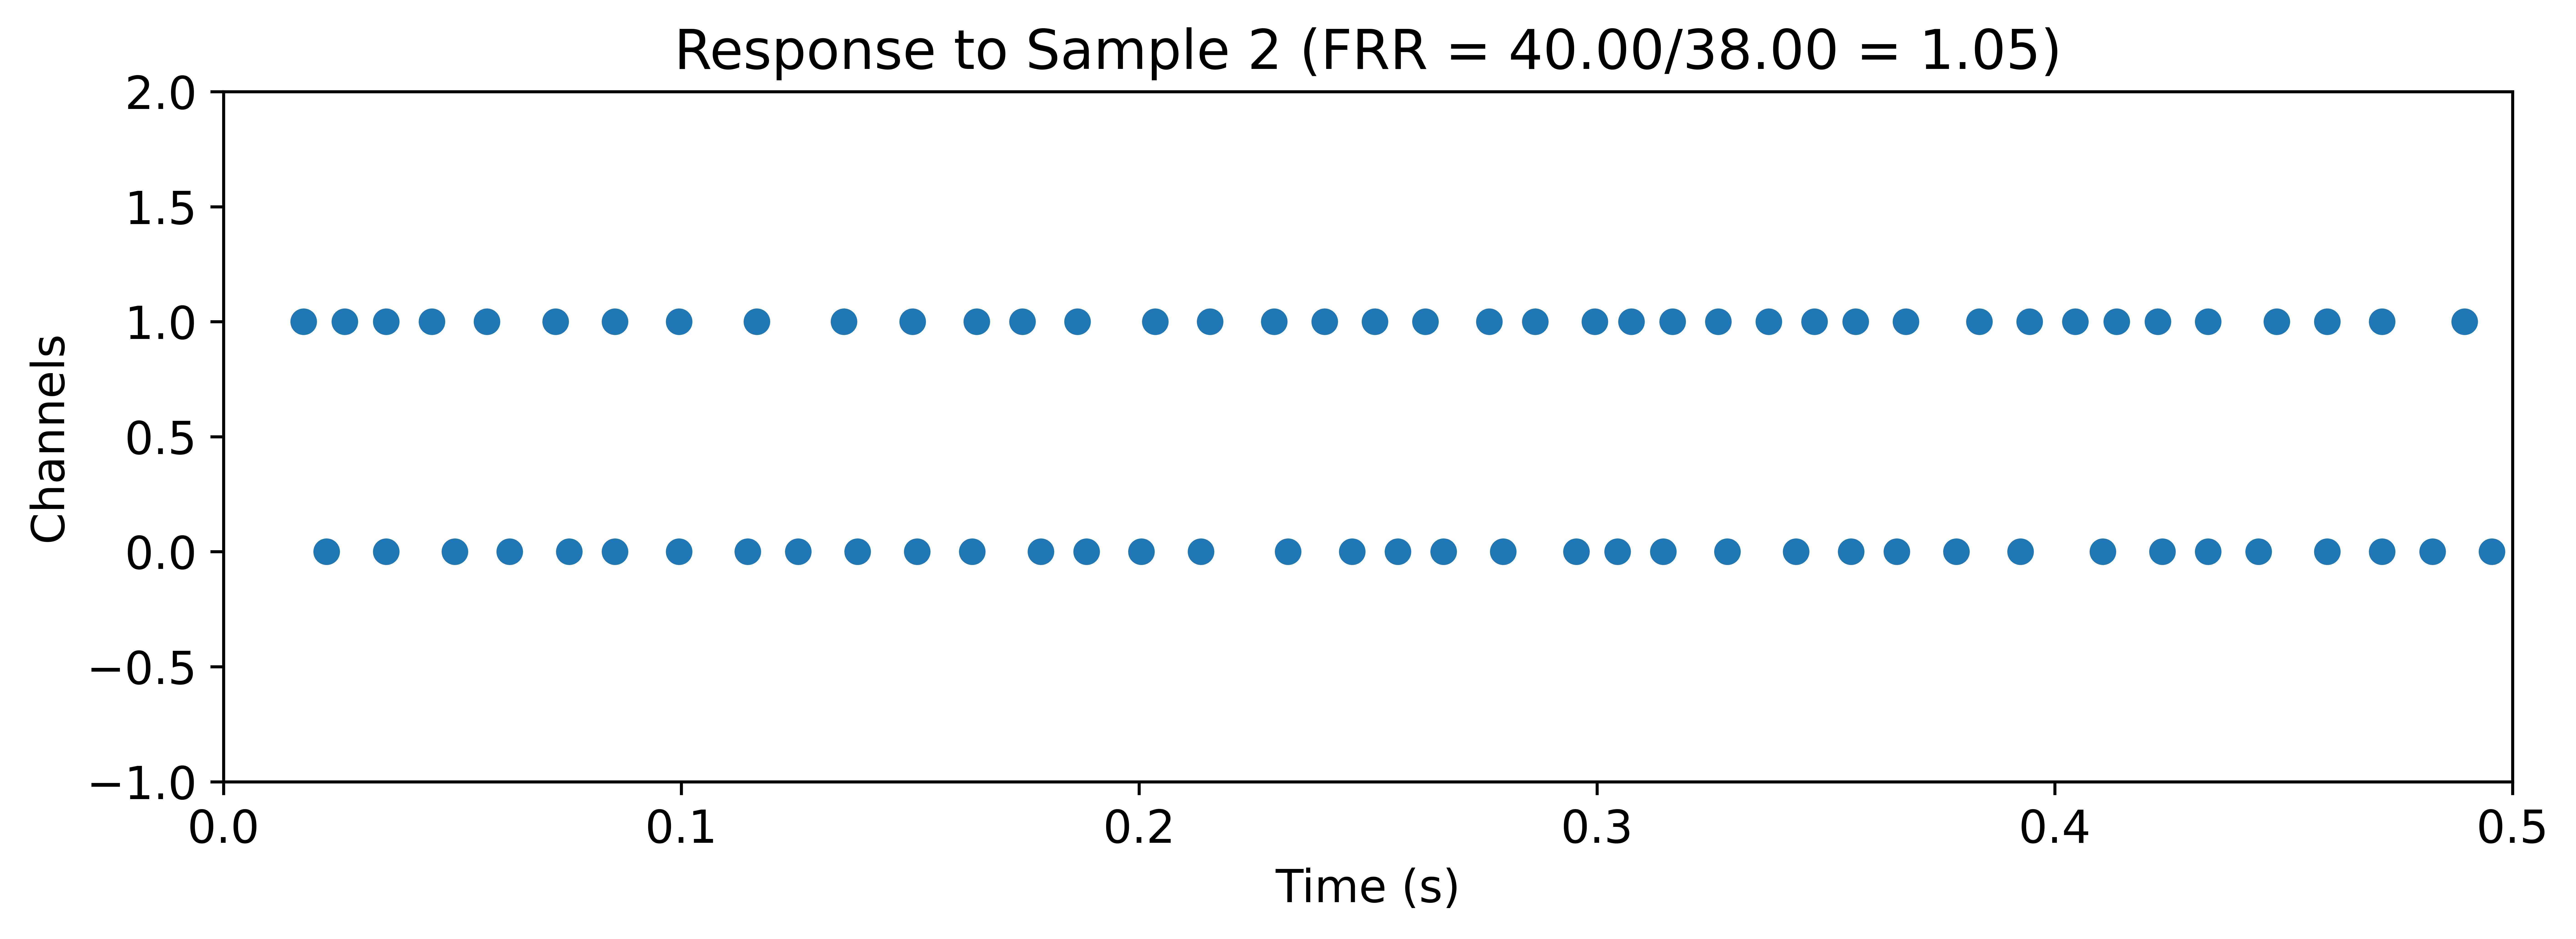

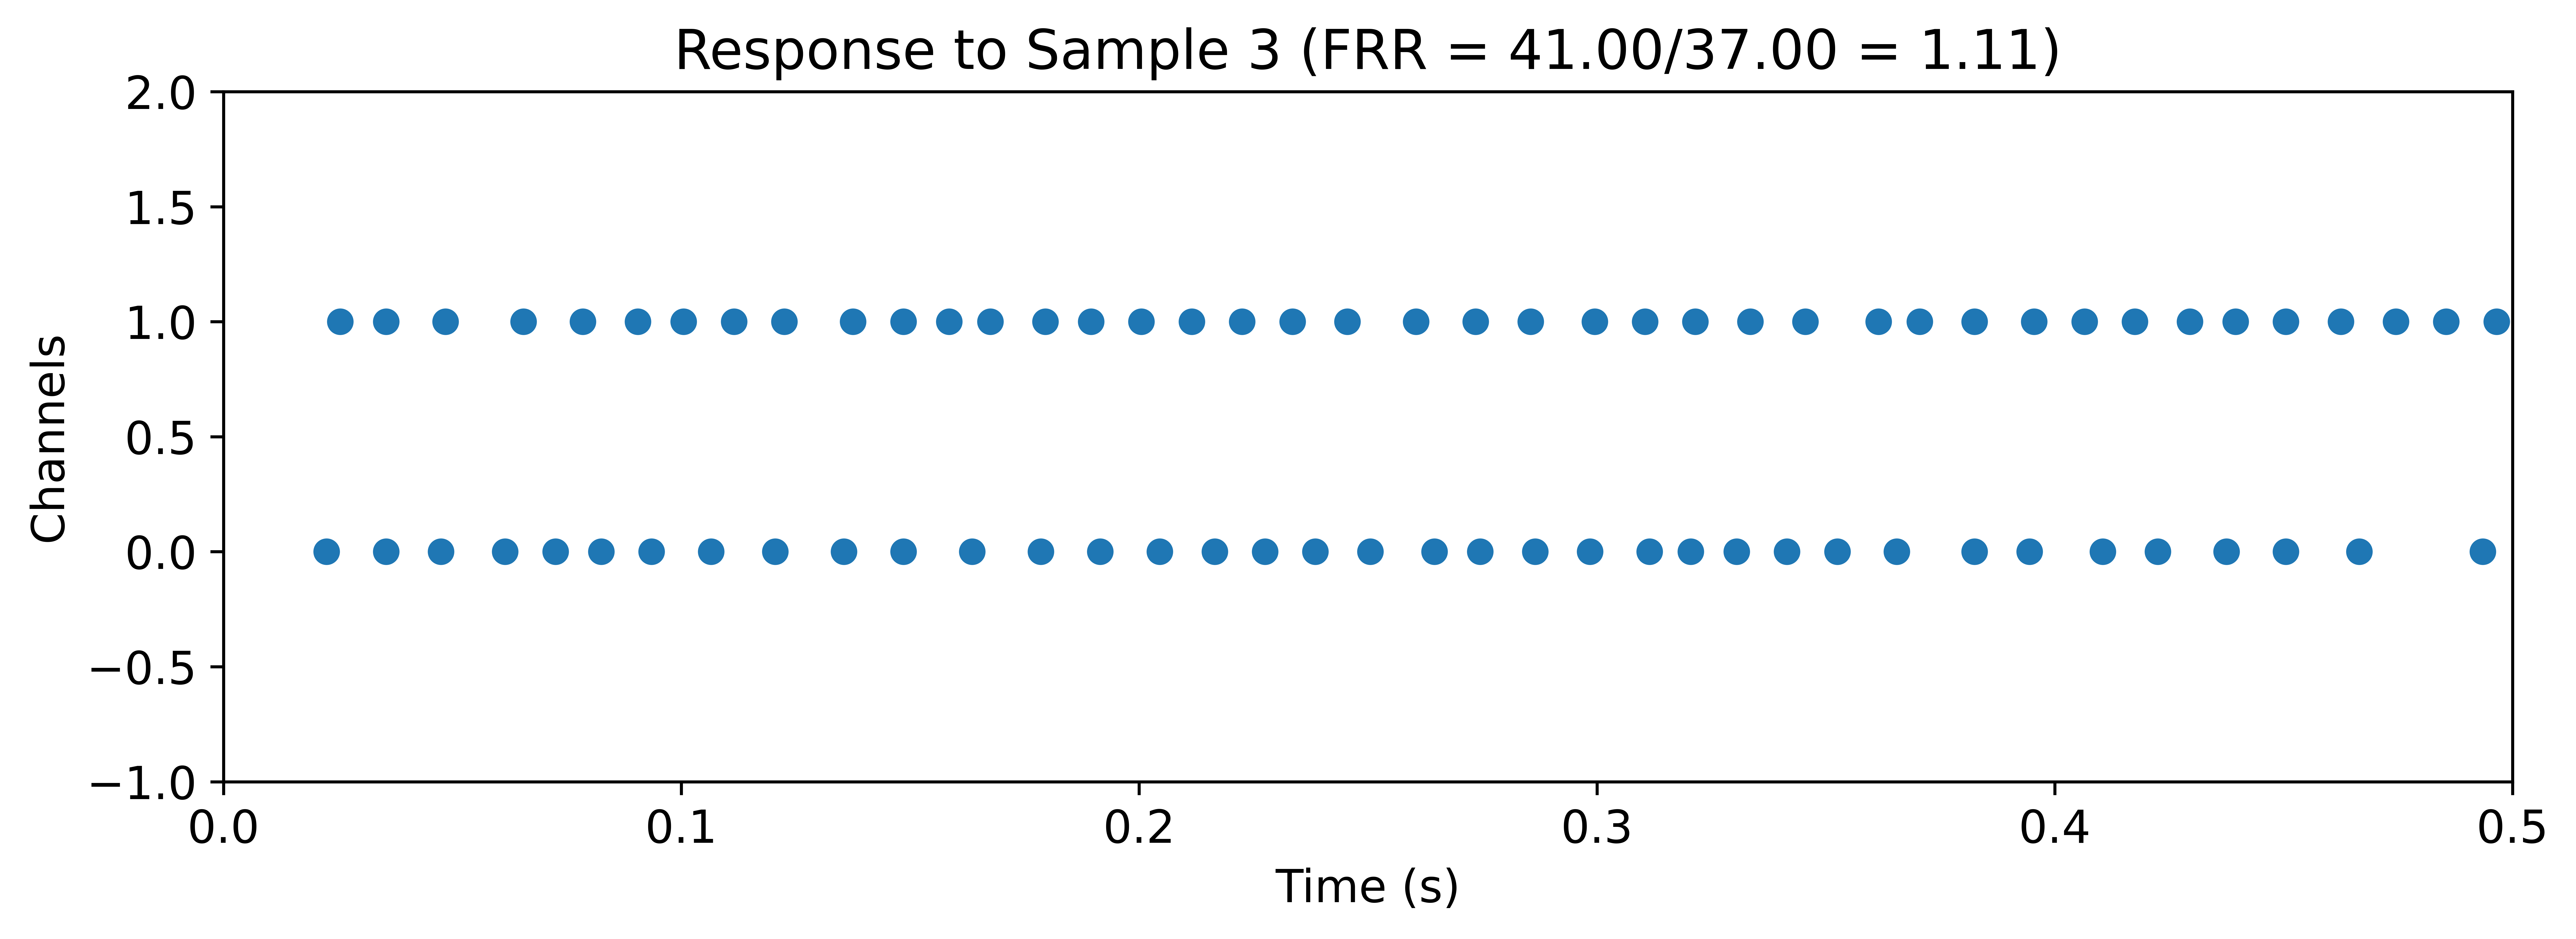

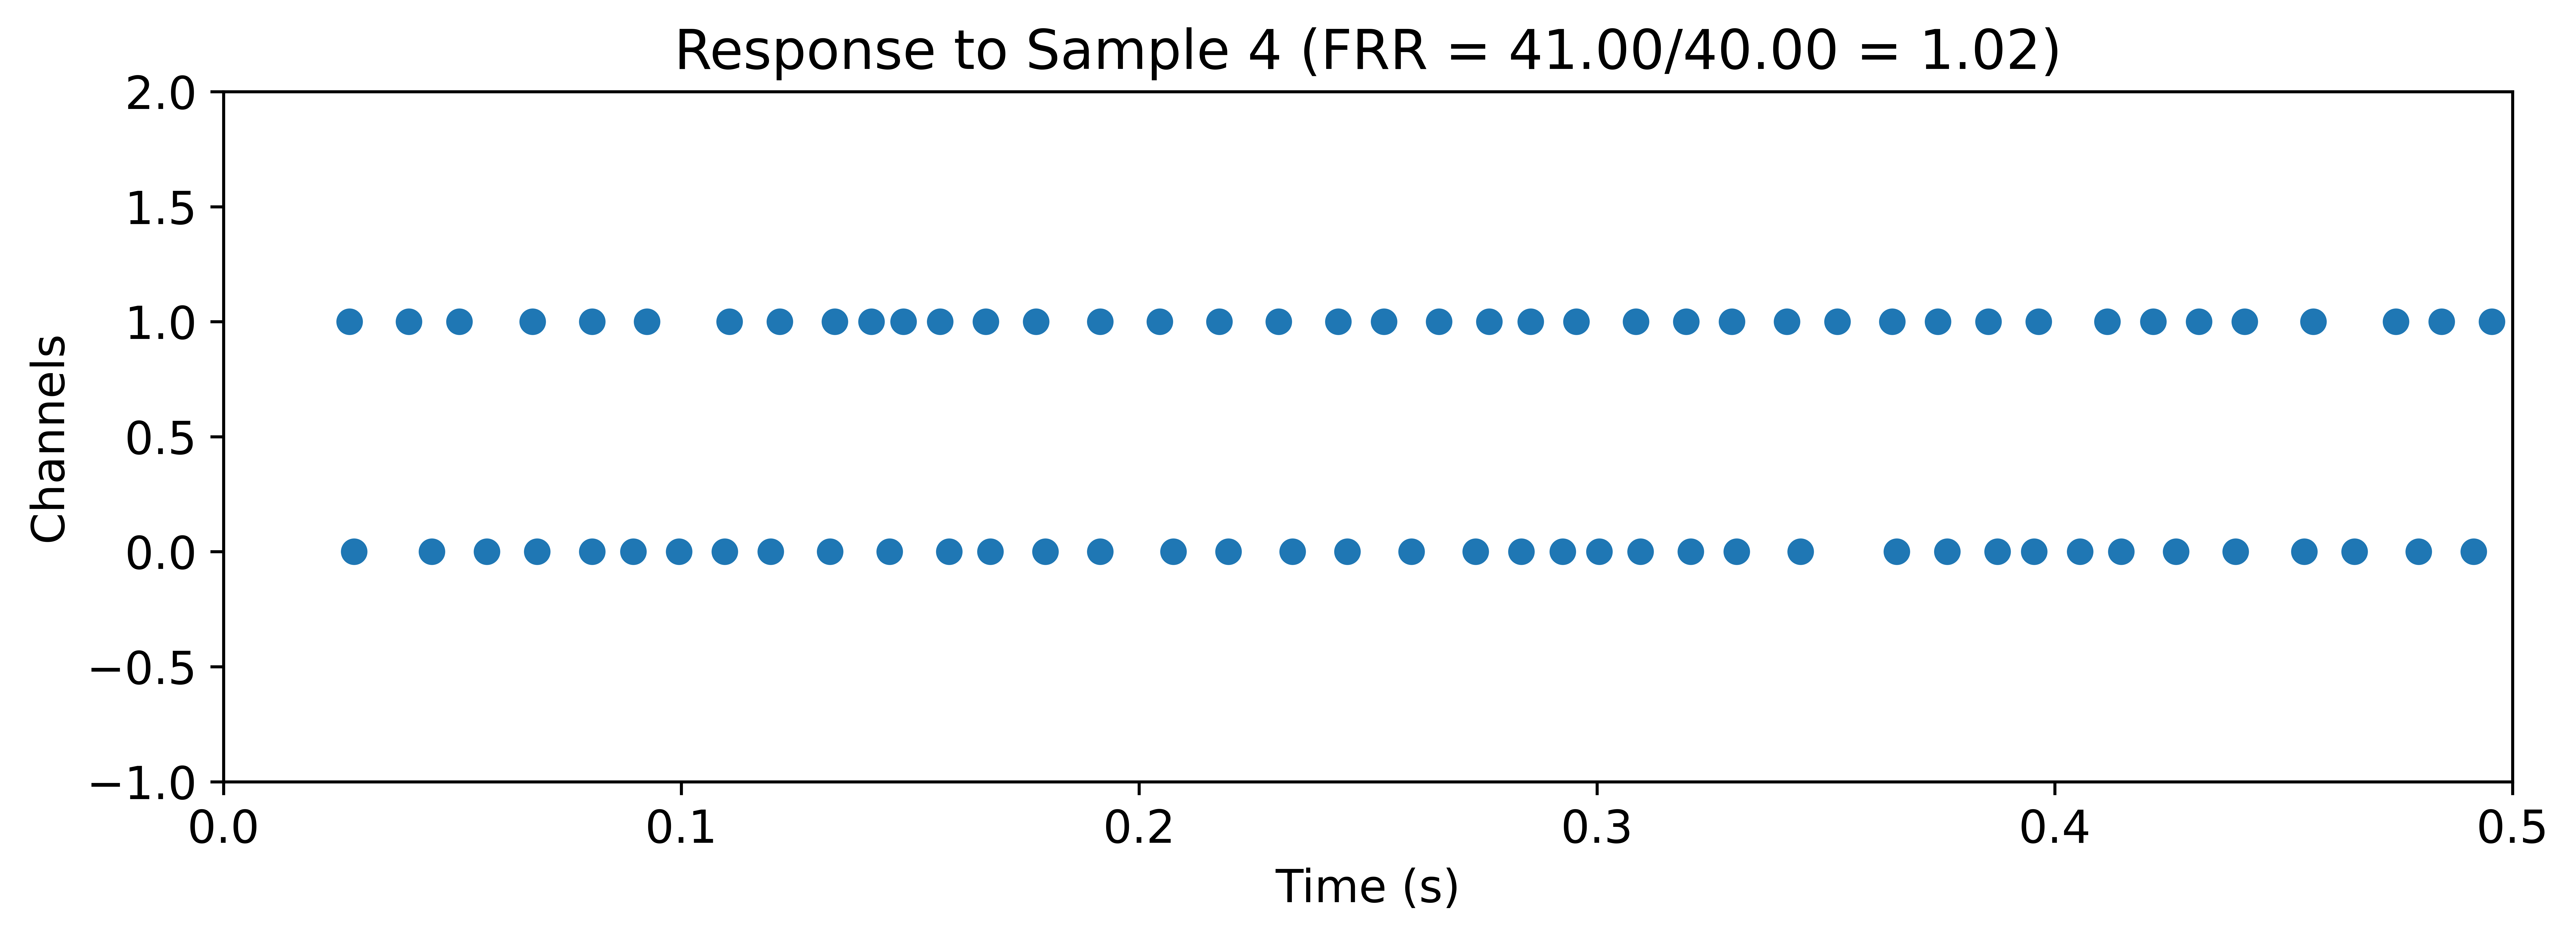

In [17]:
plot_model_response(net_optimized, test_data, dt, range(5))

It will be a long page if we plot 100 samples one after another, however, we can give an histogram showing FRR readings of all 100 test samples.

Histogram: 100 iteration [00:16,  5.93 iteration/s]               


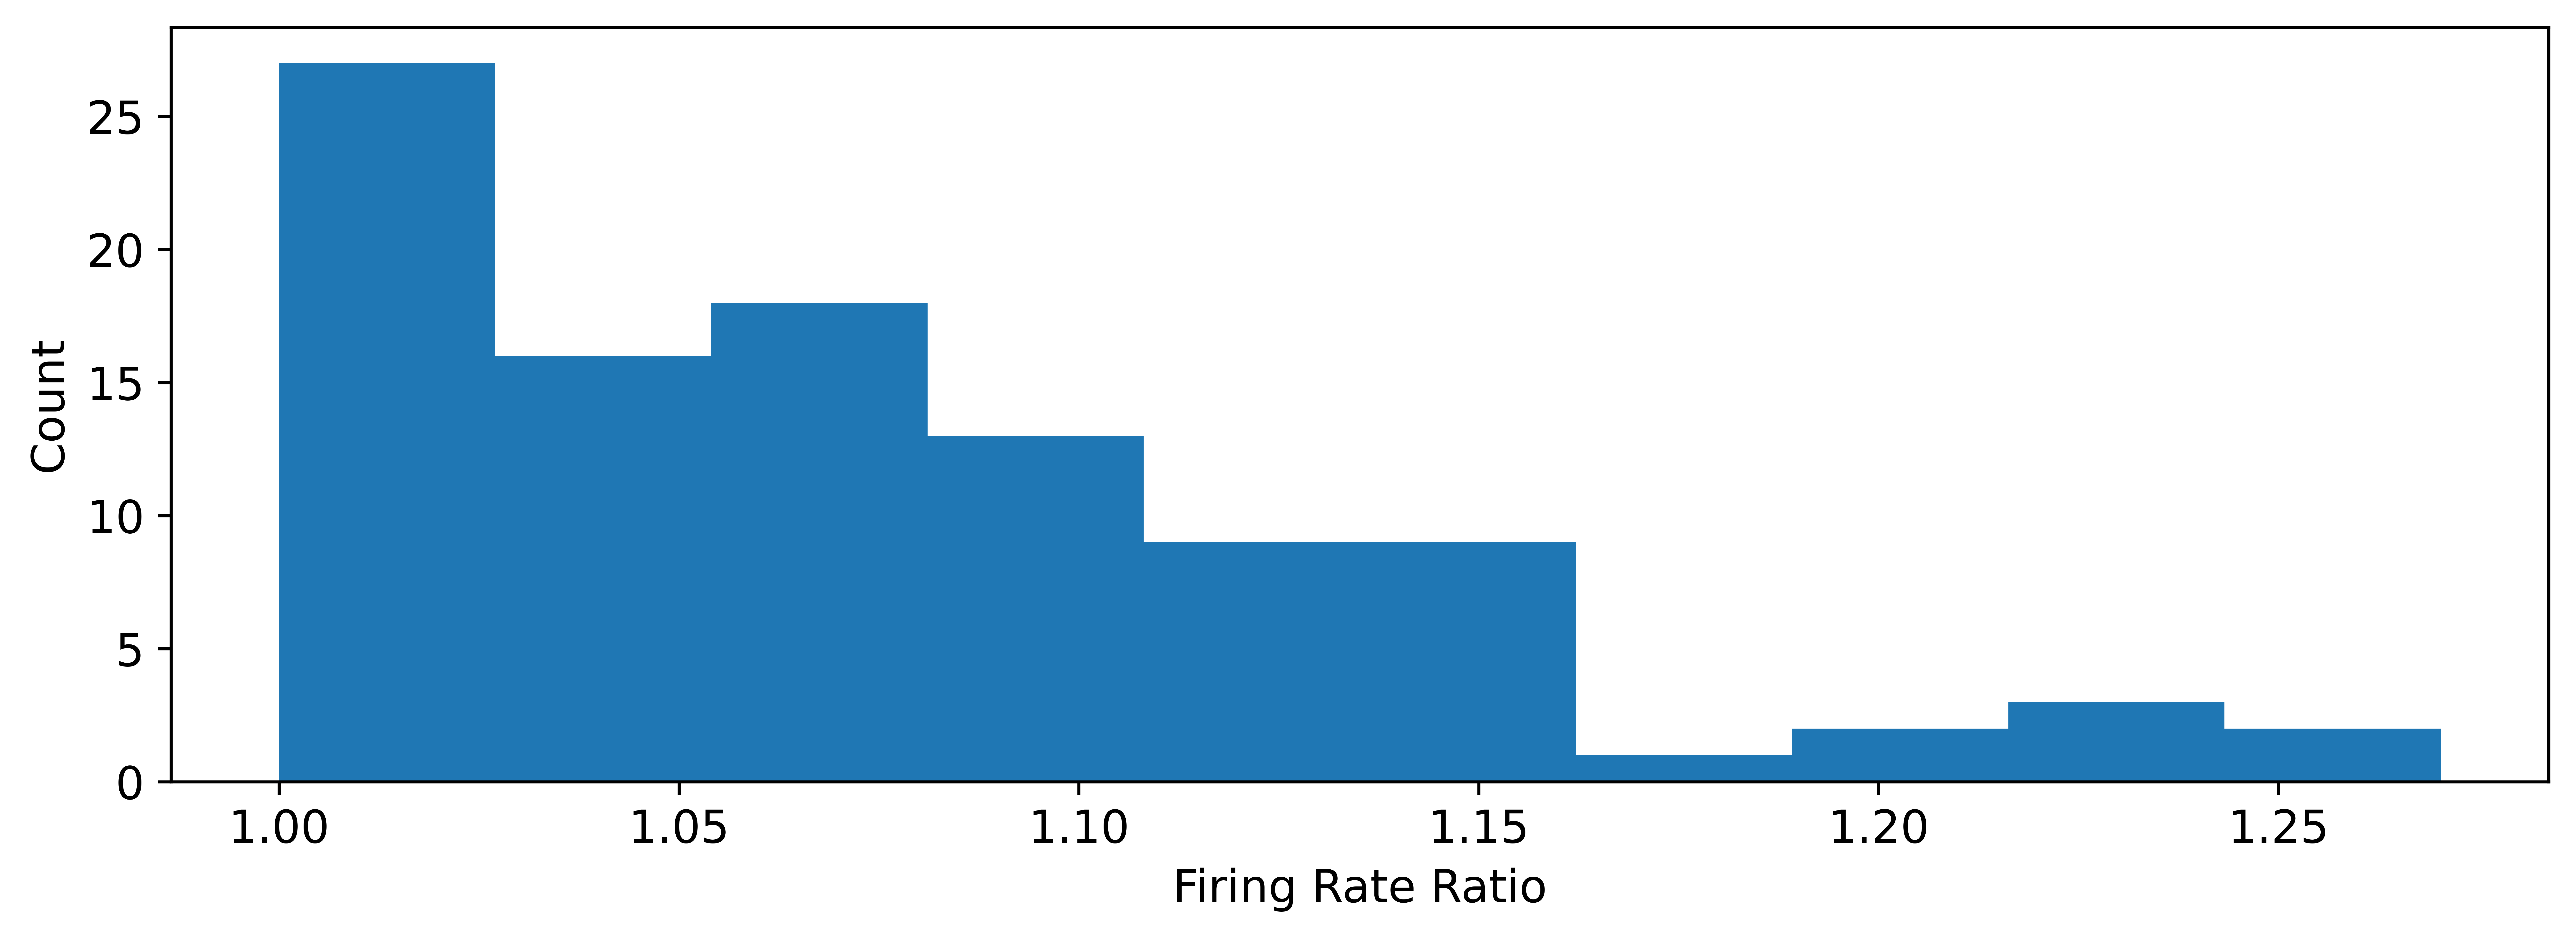

In [20]:
plot_model_response_histogram(net_optimized, test_data)

### Section 5.4 : Save the parameters for the next steps

It's great that we have a network that can recognize the frozen noise patterns using only 2 analog neurons!
In the next steps we will map this network to the hardware following some steps similar to quick start tutorial.
Let's save the network weights at this stage before doing anything else.

In [19]:
p0, p1 = get_params(opt_state).values()

with open("data/w_in_optimized.npy", "wb") as f:
    np.save(f, p0["weight"])

with open("data/w_rec_optimized.npy", "wb") as f:
    np.save(f, p1["w_rec"])

## Next steps

Please continue with the post-training tutorial to see how this network is deployed to the hardware.